<a href="https://colab.research.google.com/github/ReynaldoAVZ/Scientific-Machine-Learning-7750/blob/main/Midterm-Project/Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTANT** instruction for Problem 1: You should replace the 2D aneurysm dataset with a “spatiotemporal” dataset (scalar or vector) from your own research or lab (or an online database as explained below). Make sure you have at least 20 time-steps (ideally at least 40). If you have 3D data you can slice through it to make it 2D. You can use the aneurysm data explained below and uploaded mat file to see how to structure your data (similar to the data matrix in lectures). If you do not have any spatiotemporal data in your research group (justify why not!) then you can use the aneurysm data.

# **Bonus point** **(Data Curation)**: Online open-source datasets are ubiquitous these days. Search online to find a spatiotemporal dataset with the temporal resolution requirement above. The dataset should be related to a physical system and ideally of interest to you. Explain (document) the dataset and use it for Problem 1 below. Share the raw dataset, link to where you found it, and make it in mat format where columns are time and rows are space (similar to the sample Aneurysm dataset). 10% bonus on the exam that could be transferred to your entire course grade if you get above 100

# 1. We are given data matrix for blood flow velocity in a 2D aneurysm. The data is stored in 2D velocity vector aneu.mat. The velocity array is our typical spatiotemporal data matrix and has 3943 points and 49 time-steps (Note that this is vector data so the number of rows is 2*3943=7886). Each row first contains the x component of the velocity vector then the y component of velocity and then goes to the x and y component of the next spatial point. The coordinates array shows you the x and y coordinate position of these spatial points in the same order (useful for plotting your data). You can plot the data (e.g., velocity magnitude) using scatter plot (make sure you play with the range of colorbar to see features inside the aneurysm where the flow is very slow).

# Perform PCA (POD) on this data. Note that you can either work in vector format (no need to change the data matrix) or if you are just interested in velocity magnitude you can first pre-process the data to calculate velocity magnitude at each of the 3943 points, reduce the data matrix, and then perform PCA.

Keys in .mat: dict_keys(['__header__', '__version__', '__globals__', 'Coordinates', 'velocity'])
Coordinates shape: (3943, 2)
Velocity shape (raw): (7886, 49)
Velocity shape (used): (7886, 49)


interactive(children=(IntSlider(value=0, description='k', max=48), Output()), _dom_classes=('widget-interact',…

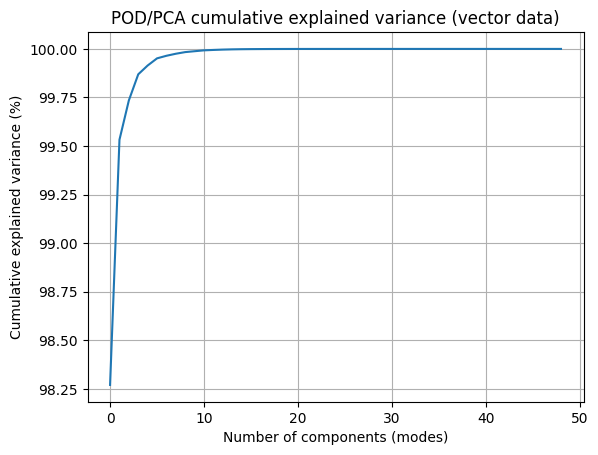

pca.components_.shape: (49, 7886)


In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA

# Load .mat 
mat_data = loadmat('2D_velocity_vector_aneu.mat')
print("Keys in .mat:", mat_data.keys())

coordinates = mat_data['Coordinates']   # expected (3943, 2)
velocity = mat_data['velocity']         # expected (7886, 49) or possibly (49, 7886)

print('Coordinates shape:', coordinates.shape)
print('Velocity shape (raw):', velocity.shape)

# Ensure velocity is (7886, 49): rows=stacked DOFs (u1,v1,u2,v2,...)
if velocity.shape[0] == 49 and velocity.shape[1] == 7886:
    velocity = velocity.T

print('Velocity shape (used):', velocity.shape)

num_points = coordinates.shape[0]
assert velocity.shape[0] == 2 * num_points, "Velocity rows should be 2*num_points (u,v stacked)."

# Split u/v from stacked rows
u = velocity[0::2, :]   # (3943, 49)
v = velocity[1::2, :]   # (3943, 49)

# Velocity magnitude at each point/time
velocity_magnitude = np.sqrt(u**2 + v**2)  # (3943, 49)

# Scatter slider to view time snapshots
x = coordinates[:, 0]
y = coordinates[:, 1]

# Use a fixed color scale across time so frames are comparable
vmin = 0.0
vmax = np.percentile(velocity_magnitude, 95)

def show_frame(k):
    plt.figure()
    sc = plt.scatter(x, y, c=velocity_magnitude[:, k], s=8, cmap='inferno',
                     vmin=vmin, vmax=vmax, linewidths=0)
    plt.colorbar(sc, label='|v|')
    plt.title(f'Velocity magnitude at time step {k}')
    plt.xlabel('x'); plt.ylabel('y')
    plt.axis('equal')
    plt.show()

interact(show_frame, k=IntSlider(min=0, max=velocity_magnitude.shape[1]-1, step=1, value=0))

# POD/PCA (vector form): snapshots are samples (time), stacked DOFs are features
# X shape: (Nt, 2*num_points) = (49, 7886)
X = velocity.T
Xc = X - X.mean(axis=0, keepdims=True)  # mean-center over time

pca = PCA()
pca.fit(Xc)

# Cumulative explained variance (energy)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of components (modes)')
plt.ylabel('Cumulative explained variance (%)')
plt.title('POD/PCA cumulative explained variance (vector data)')
plt.grid(True)
plt.show()

print("pca.components_.shape:", pca.components_.shape)  # should be (49, 7886)

## (a). Plot the first three dominant modes (velocity magnitude or vector). Set the min and max of the colorbar so you see flow features inside the aneurysm. Note that in practice forvisualization, we plot over an unstructured grid not scatter points, but here we will plot on scatter points to make the process easier. However, please do investigate and see how you can improve your simple visualization based on what you find and your data.

In [2]:
# Plot the first three dominant spatial modes (magnitude of vector mode)

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def show_mode(mode_idx):
    # Grab the mode as a vector over stacked DOFs (length 2*num_points)
    mode_vec = pca.components_[mode_idx]                 # (7886,)
    mode_uv  = mode_vec.reshape(num_points, 2)           # (3943, 2) -> [u_mode, v_mode]
    mode_mag = np.sqrt(mode_uv[:, 0]**2 + mode_uv[:, 1]**2)

    # Use a mode-specific color range to reveal slow-flow structure
    m_vmin = 0.0
    m_vmax = np.percentile(mode_mag, 95)

    plt.figure()
    sc = plt.scatter(x, y, c=mode_mag, s=8, cmap='inferno',
                     vmin=m_vmin, vmax=m_vmax, linewidths=0)
    plt.colorbar(sc, label='|mode velocity|')
    plt.title(f'POD/PCA spatial mode {mode_idx + 1} (magnitude)')
    plt.xlabel('x'); plt.ylabel('y')
    plt.axis('equal')
    plt.show()

interact(show_mode, mode_idx=IntSlider(min=0, max=50, step=1, value=0))

interactive(children=(IntSlider(value=0, description='mode_idx', max=50), Output()), _dom_classes=('widget-int…

<function __main__.show_mode(mode_idx)>

## (b). Corrupt your data in two different approaches: 1- Adding noise randomly to 80% of your data. 2- Adding noise to a local specific region (use coordinates to know the location). When you add noise you generate a random number with zero mean and standard deviation 1 from a Gaussian distribution, then you modify each data entry as: xnoisy = x+ζ∗rand∗x, where rand is the random number you generated and ζ is the level of noise. Play with different noise levels (0.05, 0.1, 0.2, etc.). As an example, ζ = 0.1 is adding 10% noise (we disturb the data by around 10% of its value with some randomness). Similar to the lecture 9 plots, for each noise level and pattern you investigated plot the singular values sorted versus mode as well as the cumulative energy (for each mode this is the sum of all singular values up to that mode normalized by the sum of all singular values). Comment on what you learn.

Local region bounds:
  x in (np.float64(2.2540430249999996), np.float64(2.5575084749999997))
  y in (np.float64(0.41998425), np.float64(0.77997075))
Points in region: 388 / 3943 (9.8%)


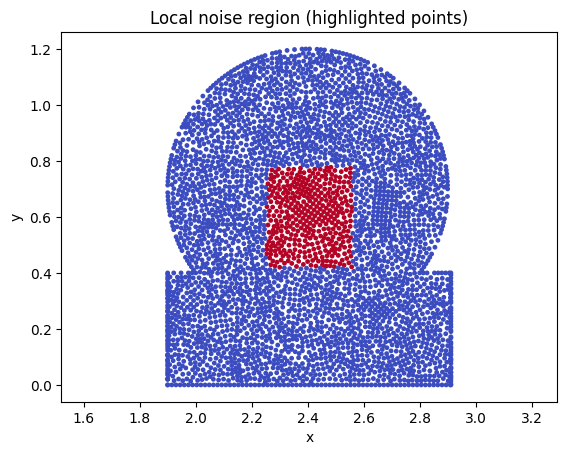

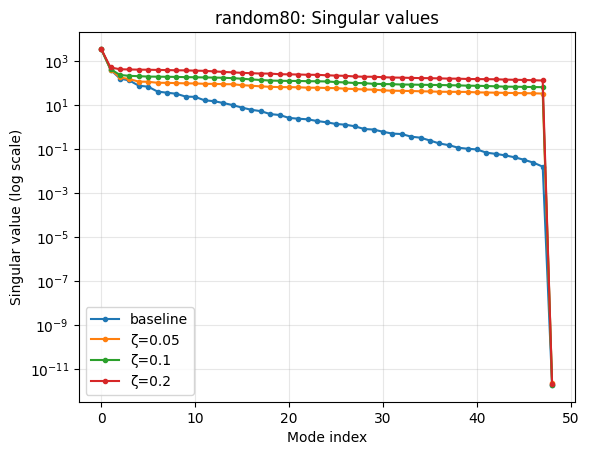

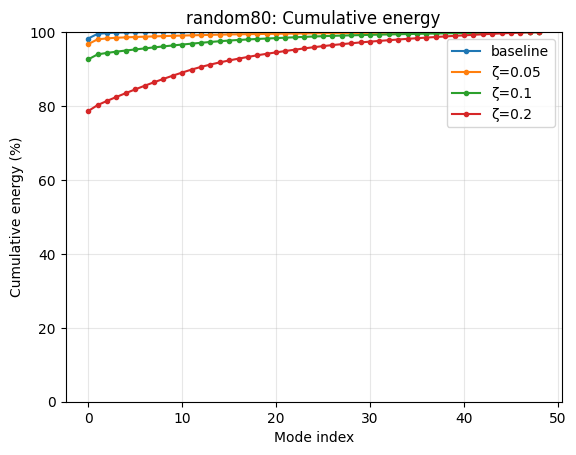

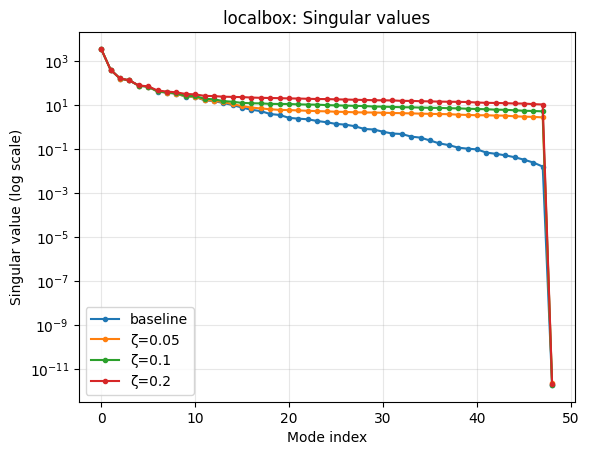

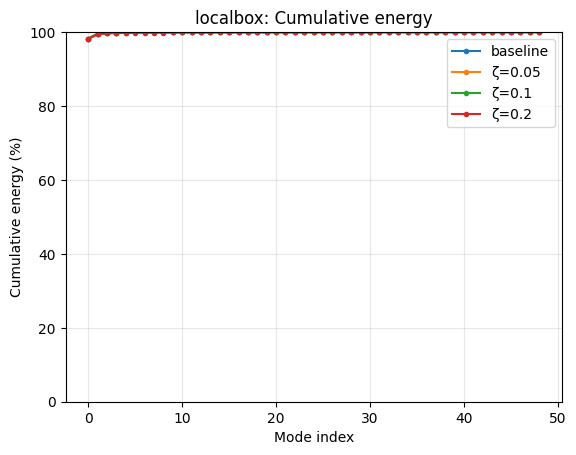

In [3]:
# Corrupt data in two ways + plot singular values & cumulative energy for multiple noise level

import numpy as np
import matplotlib.pyplot as plt

# X is (Nt, 2*num_points) = (49, 7886) from Cell 1
# coordinates is (num_points, 2)
# num_points defined in Cell 1

def svd_energy_curves(Xsnap_centered):
    """
    Compute singular values and cumulative energy curve for centered snapshot matrix.
    Xsnap_centered shape: (Nt, Ndof)
    Returns:
      S: singular values (sorted descending by default from SVD)
      cum_energy: cumulative energy fraction based on S^2
    """
    # SVD on centered data matrix
    Uc, S, Vhc = np.linalg.svd(Xsnap_centered, full_matrices=False)
    energy = (S**2) / np.sum(S**2)
    cum_energy = np.cumsum(energy)
    return S, cum_energy


def add_noise_to_mask(Xbase, mask, zeta, rng):
    """
    Apply multiplicative noise to selected entries:
        x_noisy = x + zeta * rand * x
    where rand ~ N(0,1).
    Xbase shape: (Nt, Ndof)
    mask same shape: True where noise is applied
    """
    rand = rng.standard_normal(size=Xbase.shape)
    Xnoisy = Xbase.copy()
    Xnoisy[mask] = Xbase[mask] + zeta * rand[mask] * Xbase[mask]
    return Xnoisy


def build_random_mask(shape, frac, rng):
    """Boolean mask with 'frac' fraction of entries set to True."""
    return rng.random(shape) < frac


def build_local_region_mask(coords, Xshape, x_bounds, y_bounds):
    """
    Build a mask that applies noise to *all time steps* but only to spatial points
    inside a coordinate box. Because X is vector DOFs (u,v stacked), we include
    both u and v DOFs for points in the region.

    coords shape: (num_points, 2)
    Xshape: (Nt, 2*num_points)
    x_bounds: (xmin, xmax)
    y_bounds: (ymin, ymax)
    """
    Nt, Ndof = Xshape
    x = coords[:, 0]
    y = coords[:, 1]
    in_region = (x >= x_bounds[0]) & (x <= x_bounds[1]) & (y >= y_bounds[0]) & (y <= y_bounds[1])

    # Convert point-mask (length num_points) to DOF-mask (length 2*num_points)
    dof_mask = np.zeros(2 * num_points, dtype=bool)
    dof_mask[0::2] = in_region  # u
    dof_mask[1::2] = in_region  # v

    # Apply to all time steps
    mask = np.tile(dof_mask, (Nt, 1))
    return mask, in_region


def plot_svd_results(S_list, CE_list, labels, title_prefix):
    """
    Plot singular values and cumulative energy curves.
    S_list: list of arrays of singular values
    CE_list: list of arrays of cumulative energy
    labels: list of strings
    """
    # Singular values (log scale helps)
    plt.figure()
    for S, lab in zip(S_list, labels):
        plt.plot(S, marker='o', linestyle='-', markersize=3, label=lab)
    plt.yscale('log')
    plt.xlabel('Mode index')
    plt.ylabel('Singular value (log scale)')
    plt.title(f'{title_prefix}: Singular values')
    plt.grid(True, which='both', alpha=0.3)
    plt.legend()
    plt.show()

    # Cumulative energy
    plt.figure()
    for ce, lab in zip(CE_list, labels):
        plt.plot(ce * 100, marker='o', linestyle='-', markersize=3, label=lab)
    plt.xlabel('Mode index')
    plt.ylabel('Cumulative energy (%)')
    plt.title(f'{title_prefix}: Cumulative energy')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.legend()
    plt.show()


# ---------- Baseline (no noise) ----------
Xc_base = X - X.mean(axis=0, keepdims=True)
S0, ce0 = svd_energy_curves(Xc_base)

# ---------- Noise experiments ----------
zetas = [0.05, 0.10, 0.20]  # you can add more
rng = np.random.default_rng(0)  # reproducible

# 1) Randomly add noise to 80% of entries
frac_corrupt = 0.80
random_masks = {z: build_random_mask(X.shape, frac_corrupt, rng) for z in zetas}

# 2) Add noise to a local region (choose a box in the coordinate domain)
# Pick a box relative to the data bounding box (you can tweak these!)
xmin, xmax = coordinates[:, 0].min(), coordinates[:, 0].max()
ymin, ymax = coordinates[:, 1].min(), coordinates[:, 1].max()

# Example: central-ish box (middle 30% of x and y range)
x_bounds = (xmin + 0.35*(xmax-xmin), xmin + 0.65*(xmax-xmin))
y_bounds = (ymin + 0.35*(ymax-ymin), ymin + 0.65*(ymax-ymin))

local_mask, in_region_points = build_local_region_mask(coordinates, X.shape, x_bounds, y_bounds)

print("Local region bounds:")
print("  x in", x_bounds)
print("  y in", y_bounds)
print(f"Points in region: {in_region_points.sum()} / {num_points} ({100*in_region_points.mean():.1f}%)")

# Optional: visualize the chosen noisy region
plt.figure()
plt.scatter(coordinates[:,0], coordinates[:,1], s=6, c=in_region_points.astype(int), cmap='coolwarm')
plt.title("Local noise region (highlighted points)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.show()

# ---------- Run and plot for each corruption type ----------
for pattern in ["random80", "localbox"]:
    S_list = [S0]
    CE_list = [ce0]
    labels = ["baseline"]

    for z in zetas:
        if pattern == "random80":
            mask = random_masks[z]
            Xnoisy = add_noise_to_mask(X, mask, z, rng)
            title_prefix = f"Noise pattern: random 80% (ζ={z})"
            lab = f"ζ={z}"
        else:
            Xnoisy = add_noise_to_mask(X, local_mask, z, rng)
            title_prefix = f"Noise pattern: local region (ζ={z})"
            lab = f"ζ={z}"

        # Center over time (same preprocessing as baseline)
        Xc = Xnoisy - Xnoisy.mean(axis=0, keepdims=True)

        S, ce = svd_energy_curves(Xc)
        S_list.append(S)
        CE_list.append(ce)
        labels.append(lab)

    # For each pattern, plot all zetas + baseline together
    plot_svd_results(S_list, CE_list, labels, title_prefix=pattern)


## (c). Perform RPCA and repeat the above to see how RPCA improves your results under noise (you might need to play with the hyperparameter λ in RPCA). Report on RPCA’s performance based on noise level and pattern (random vs. localized)

Local region bounds:
  x in (np.float64(2.2540430249999996), np.float64(2.5575084749999997))
  y in (np.float64(0.41998425), np.float64(0.77997075))
Points in region: 388 / 3943 (9.8%)


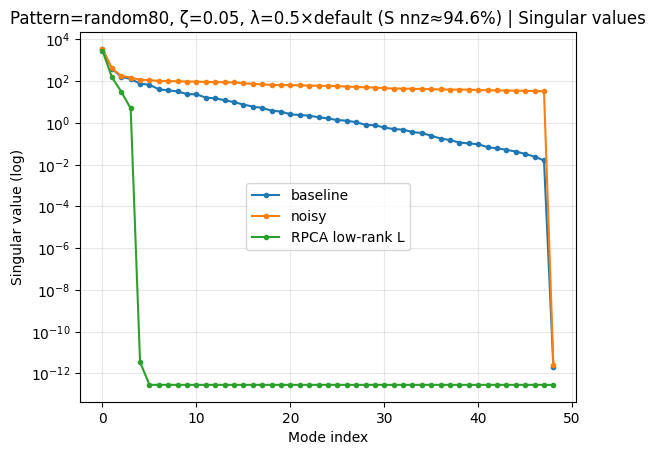

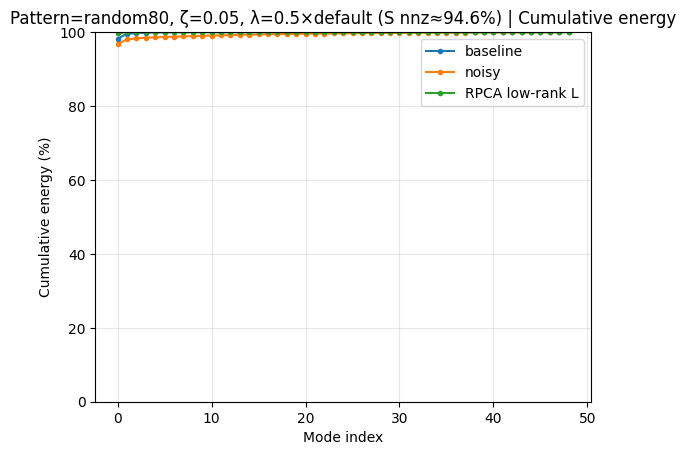

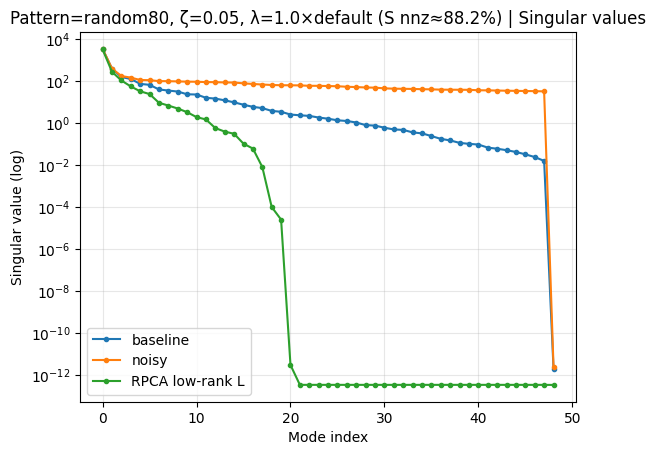

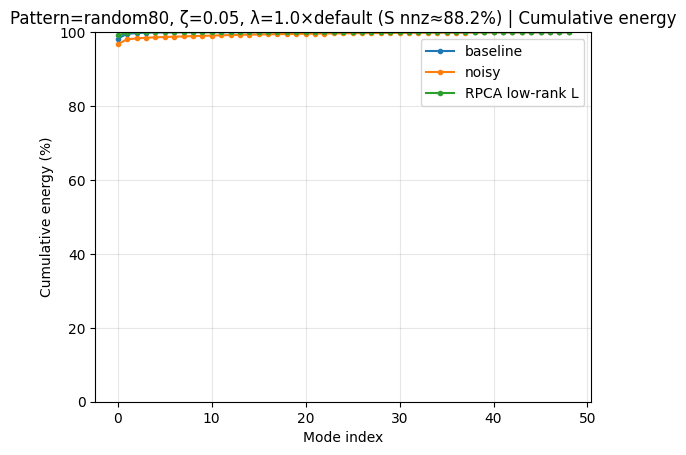

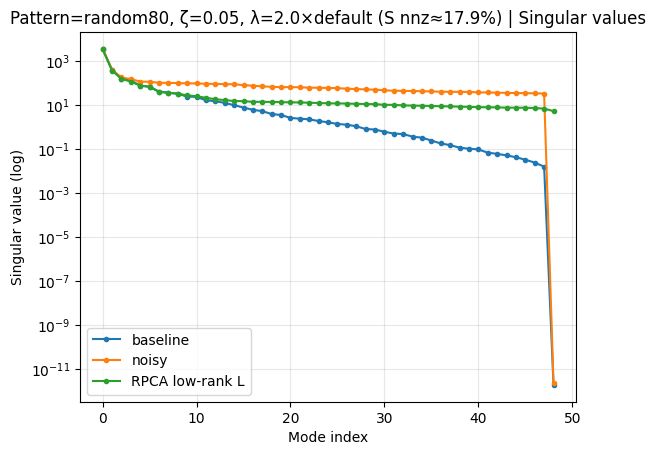

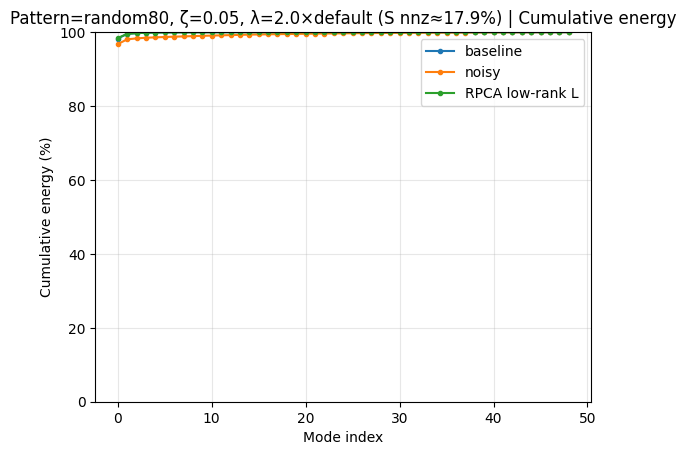

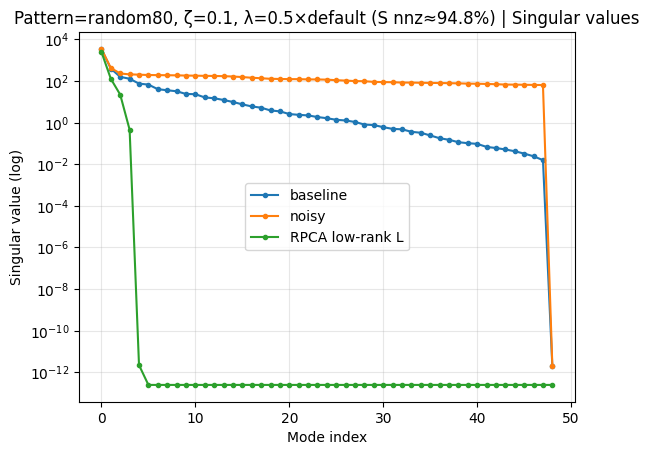

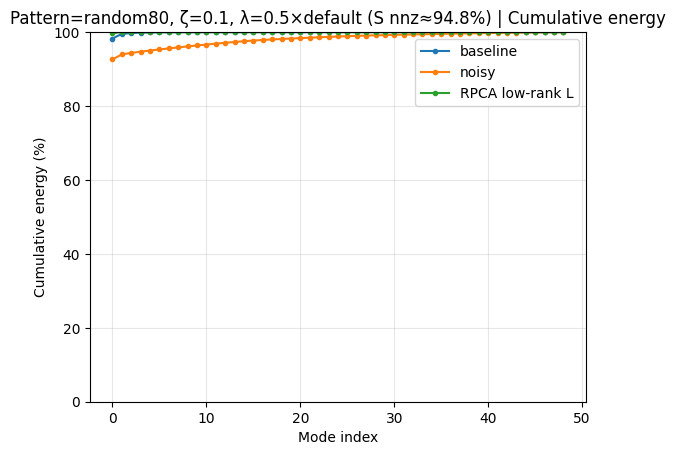

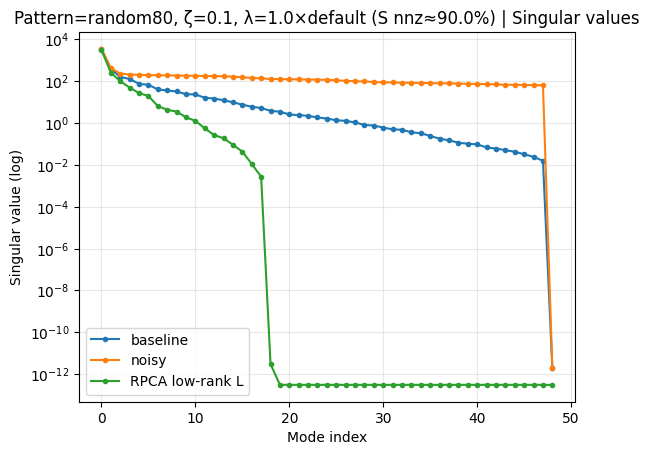

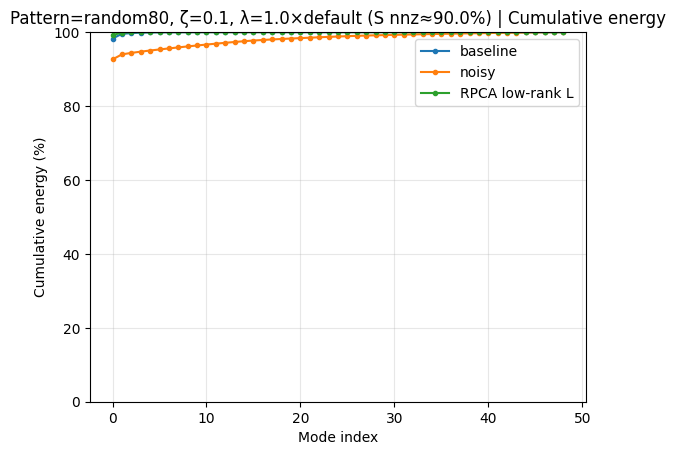

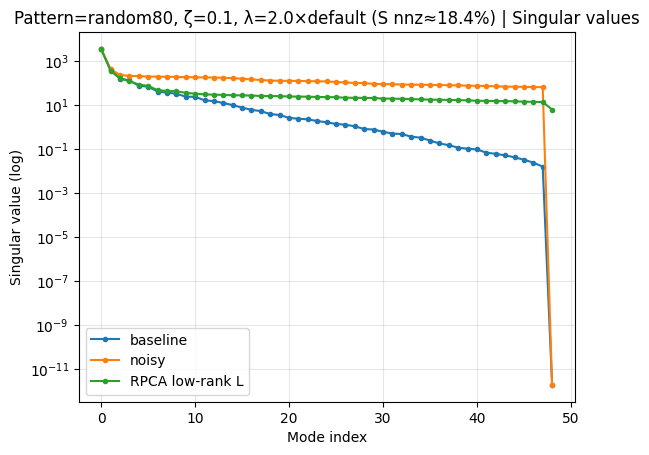

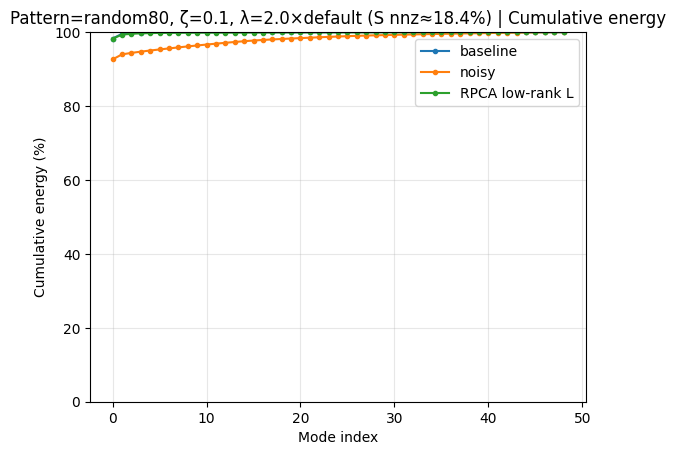

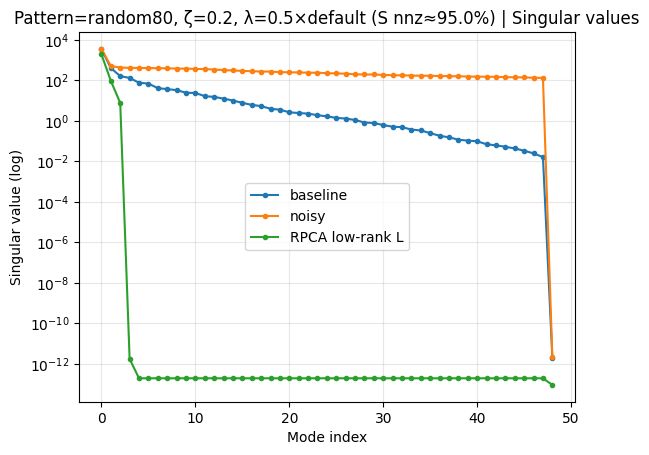

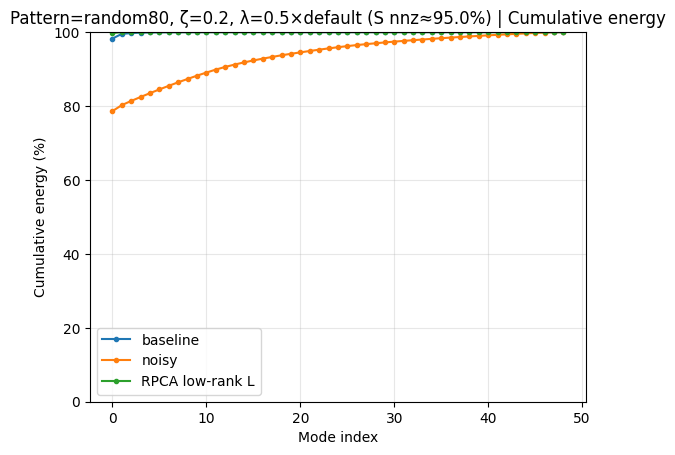

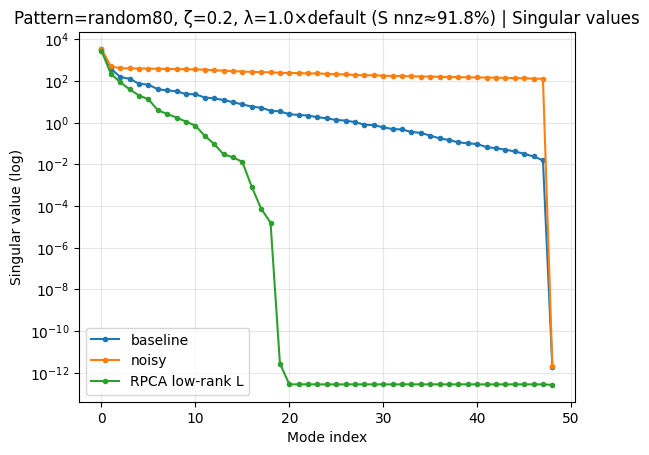

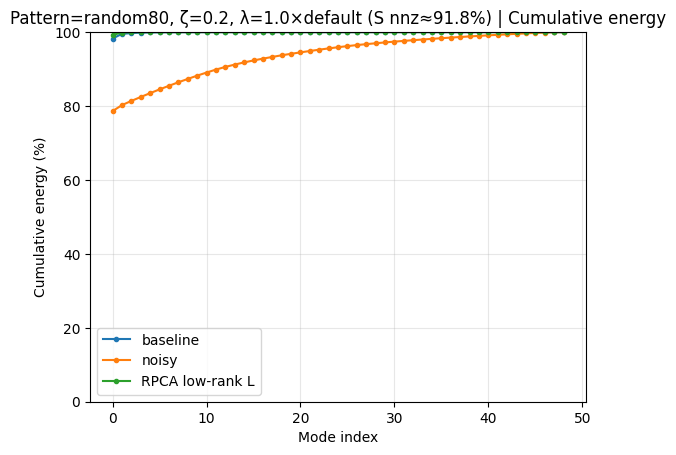

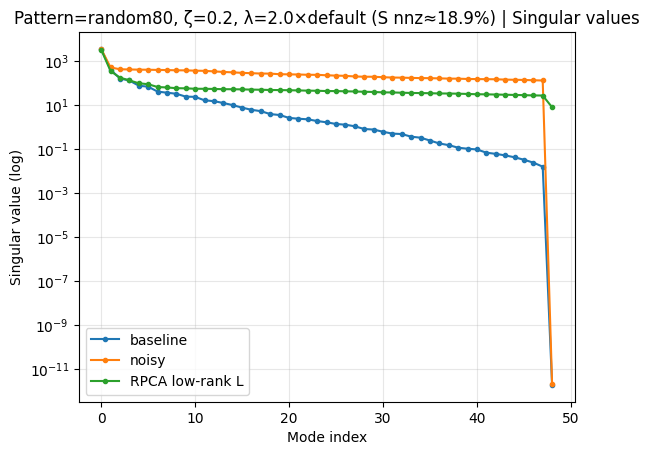

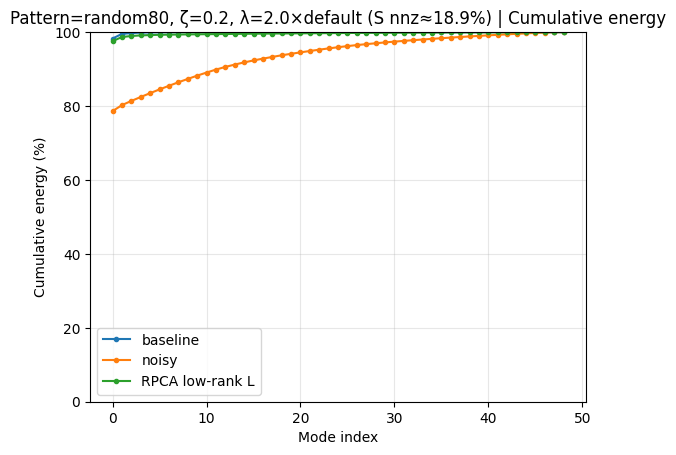

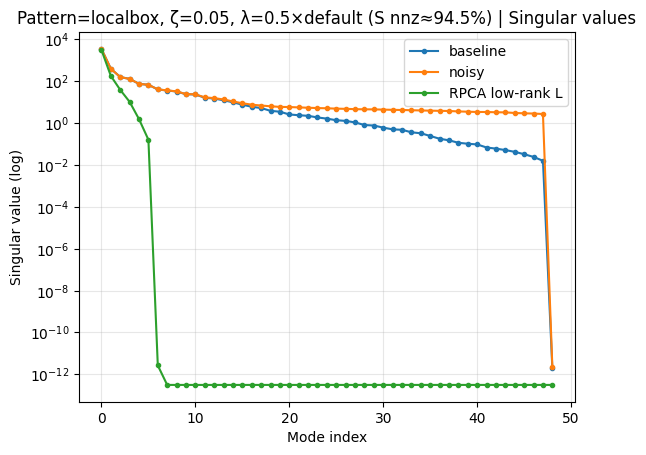

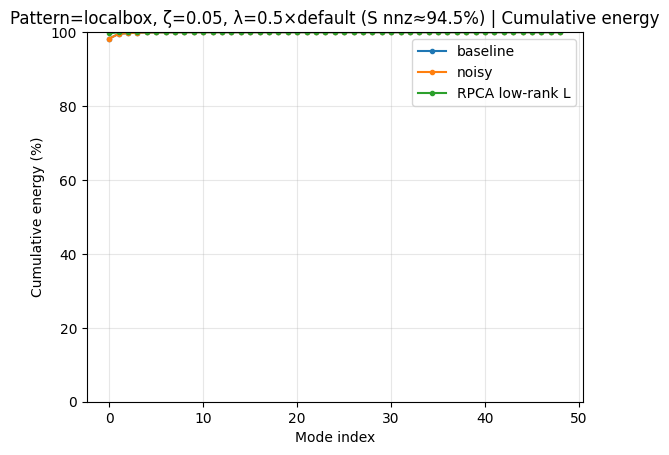

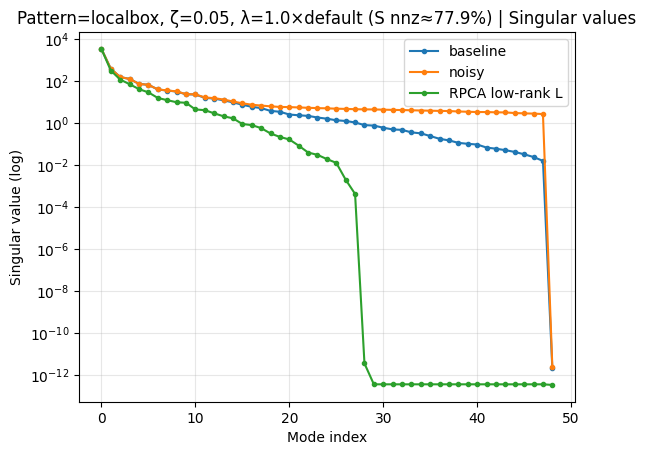

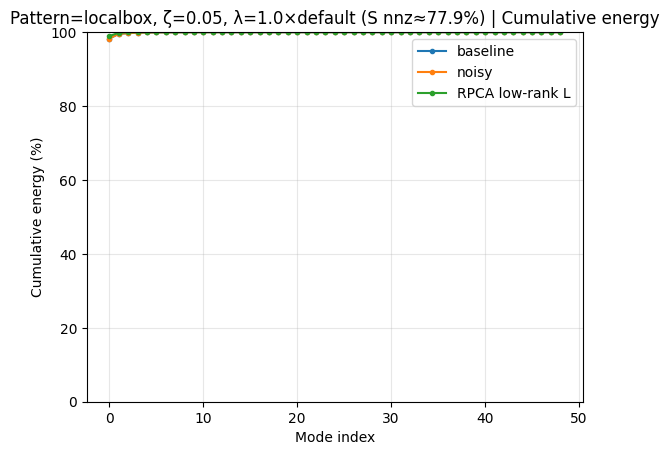

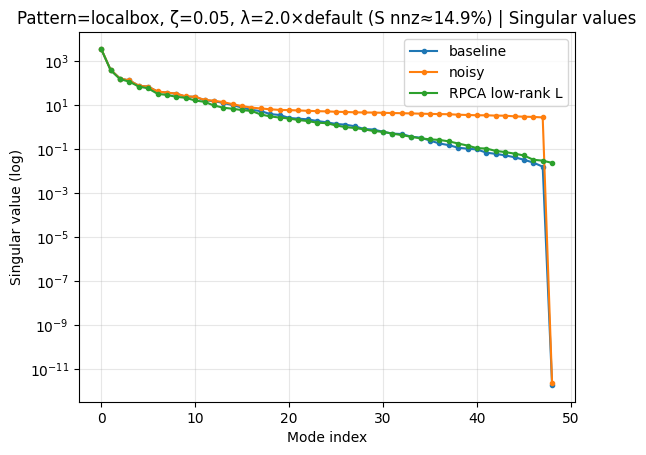

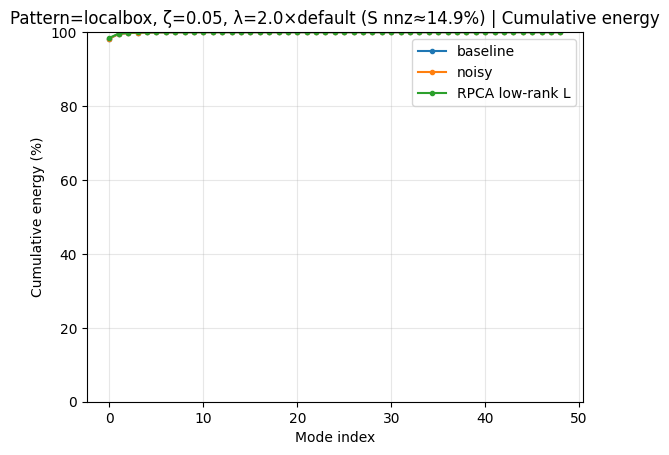

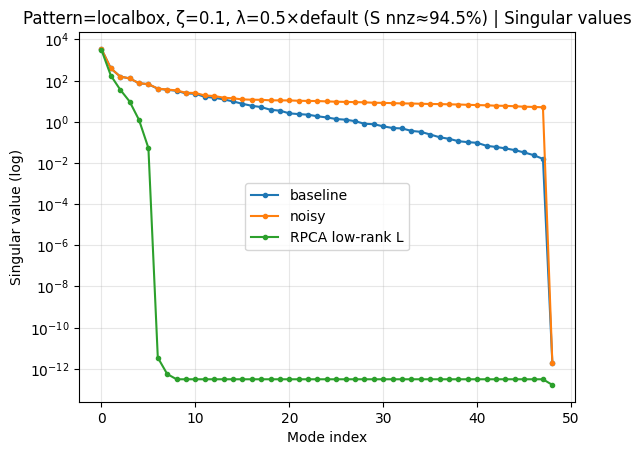

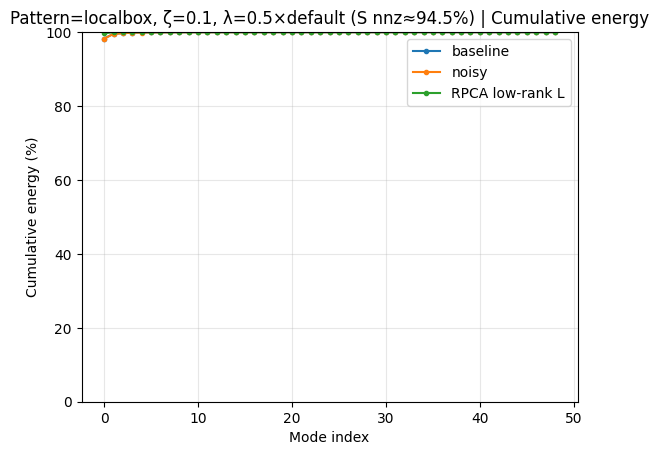

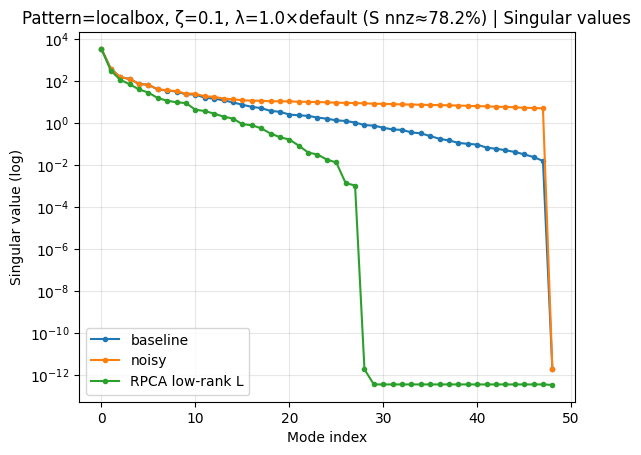

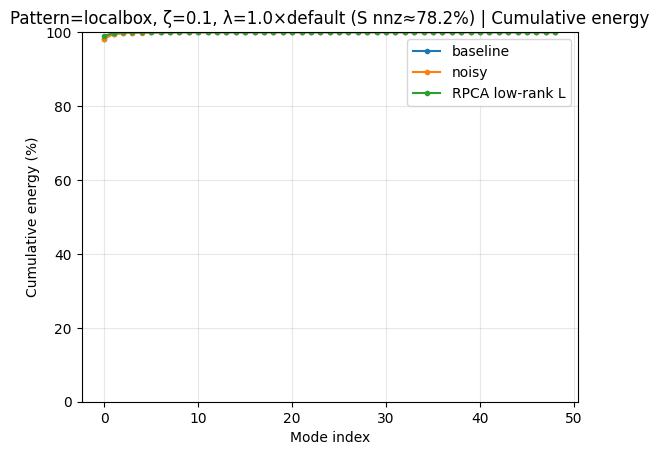

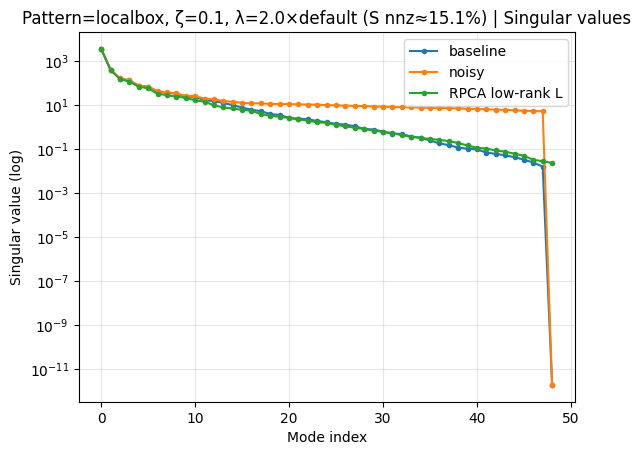

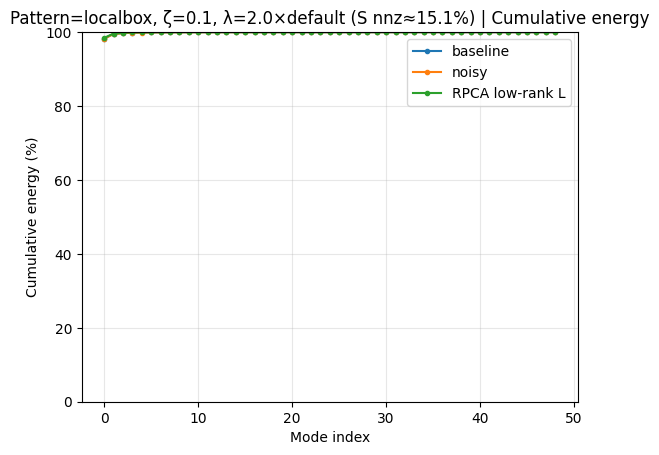

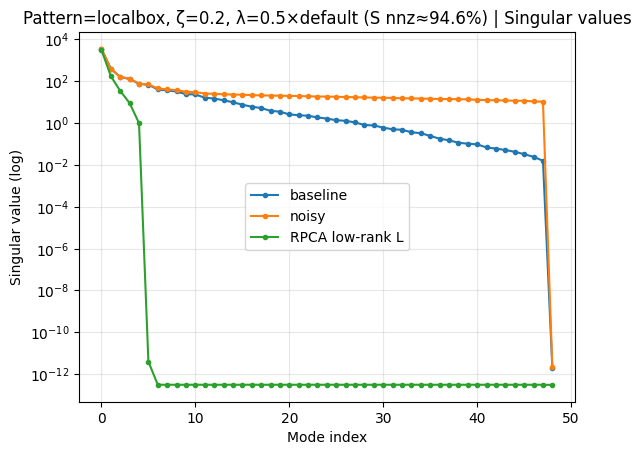

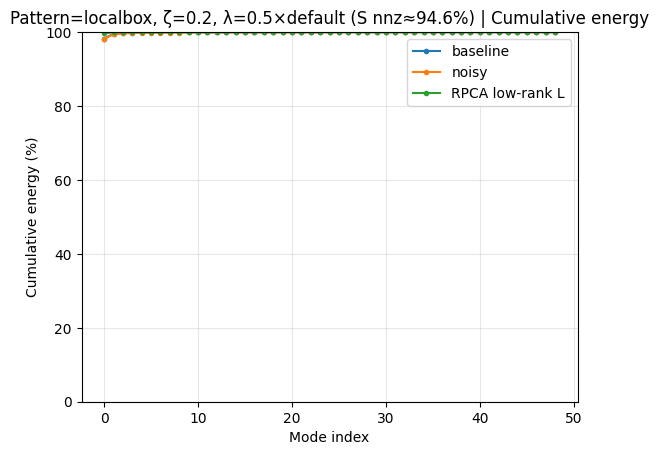

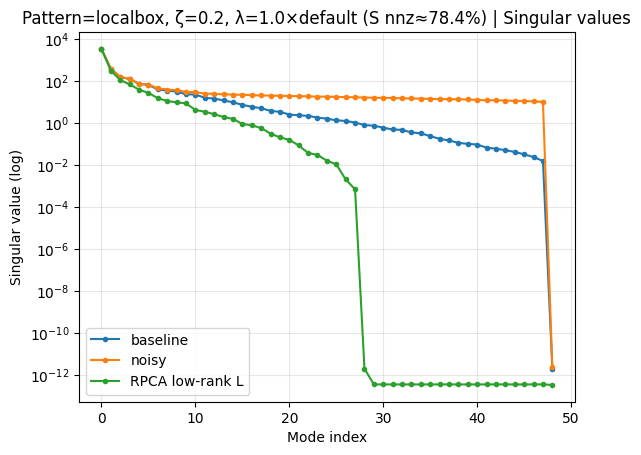

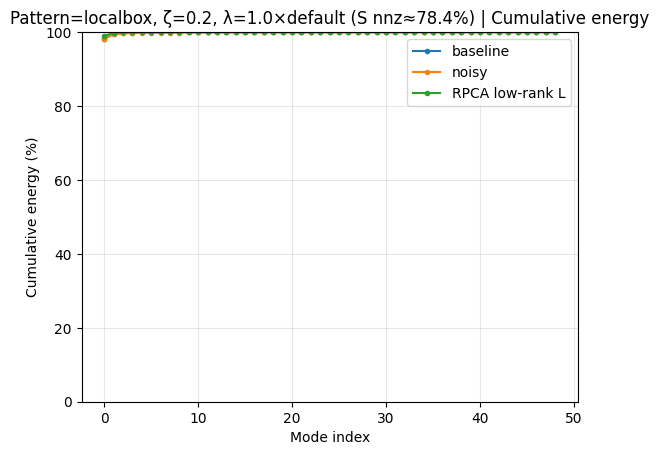

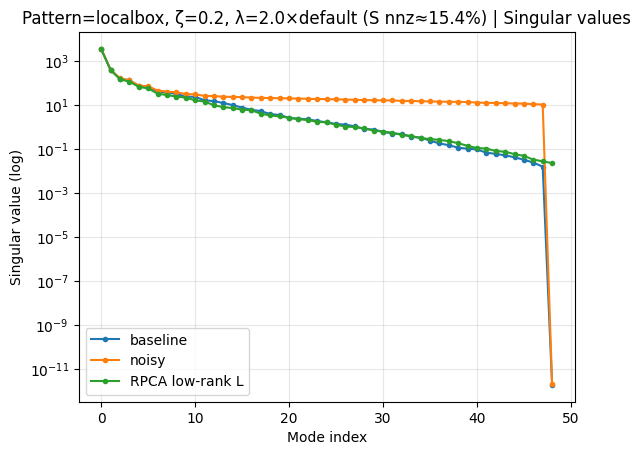

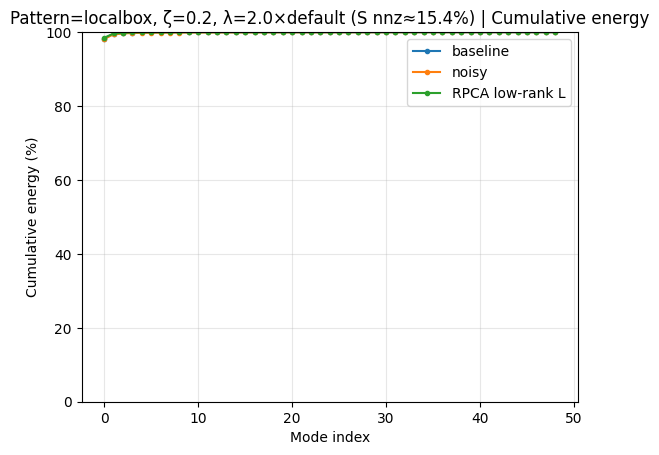

Done. For your report, compare:
  - how close RPCA(L) spectra look to baseline vs noisy
  - whether RPCA helps more for local noise than random80
  - how tuning λ changes sparsity of S and quality of L


In [4]:
# === Cell (c): RPCA (PCP) + compare spectra under noise patterns/levels ===

import numpy as np
import matplotlib.pyplot as plt

assert 'X' in globals(), "Run Cell 1 first (needs X)."
assert 'coordinates' in globals(), "Run Cell 1 first (needs coordinates)."
assert 'num_points' in globals(), "Run Cell 1 first (needs num_points)."

# -----------------------------
# RPCA via Inexact Augmented Lagrange Multiplier (IALM)
# Solves: min ||L||_* + lam ||S||_1  s.t. D = L + S
# -----------------------------

def soft_threshold(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0.0)

def svt(X, tau):
    # Singular Value Thresholding: U diag(max(s - tau, 0)) Vh
    U, s, Vh = np.linalg.svd(X, full_matrices=False)
    s_thresh = np.maximum(s - tau, 0.0)
    return (U * s_thresh) @ Vh

def rpca_ialm(D, lam=None, tol=1e-7, max_iter=500, verbose=False):
    """
    D: (m, n) data matrix
    lam: lambda parameter; default 1/sqrt(max(m,n))
    returns L, S
    """
    m, n = D.shape
    if lam is None:
        lam = 1.0 / np.sqrt(max(m, n))

    # Initialize
    L = np.zeros_like(D)
    S = np.zeros_like(D)

    # Dual variable
    Y = D / max(np.linalg.norm(D, 2), np.linalg.norm(D.ravel(), np.inf) / lam + 1e-12)

    # mu schedule (common heuristic)
    mu = 1.25 / (np.linalg.norm(D, 2) + 1e-12)
    mu_bar = mu * 1e7
    rho = 1.5

    D_norm = np.linalg.norm(D, 'fro') + 1e-12

    for it in range(max_iter):
        # Update low-rank part via SVT
        L = svt(D - S + (1.0/mu)*Y, 1.0/mu)

        # Update sparse part via soft-thresholding
        S = soft_threshold(D - L + (1.0/mu)*Y, lam/mu)

        # Update dual
        Z = D - L - S
        Y = Y + mu * Z

        # Convergence check
        err = np.linalg.norm(Z, 'fro') / D_norm
        if verbose and (it % 25 == 0 or it == max_iter-1):
            nnz = np.mean(np.abs(S) > 1e-12) * 100
            print(f"iter={it:4d}  rel_err={err:.2e}  S_nnz={nnz:.1f}%  mu={mu:.2e}")

        if err < tol:
            break

        mu = min(mu * rho, mu_bar)

    return L, S

# -----------------------------
# Helpers to compute & plot spectra
# -----------------------------

def svd_energy_curves(Xsnap_centered):
    # Xsnap_centered shape: (Nt, Ndof)
    _, S, _ = np.linalg.svd(Xsnap_centered, full_matrices=False)
    energy = (S**2) / np.sum(S**2)
    cum_energy = np.cumsum(energy)
    return S, cum_energy

def add_noise_to_mask(Xbase, mask, zeta, rng):
    rand = rng.standard_normal(size=Xbase.shape)
    Xnoisy = Xbase.copy()
    Xnoisy[mask] = Xbase[mask] + zeta * rand[mask] * Xbase[mask]
    return Xnoisy

def build_random_mask(shape, frac, rng):
    return rng.random(shape) < frac

def build_local_region_mask(coords, Xshape, x_bounds, y_bounds, num_points):
    Nt, Ndof = Xshape
    x = coords[:, 0]
    y = coords[:, 1]
    in_region = (x >= x_bounds[0]) & (x <= x_bounds[1]) & (y >= y_bounds[0]) & (y <= y_bounds[1])

    dof_mask = np.zeros(2 * num_points, dtype=bool)
    dof_mask[0::2] = in_region
    dof_mask[1::2] = in_region

    mask = np.tile(dof_mask, (Nt, 1))
    return mask, in_region

def plot_compare_spectra(S_base, CE_base, S_noisy, CE_noisy, S_rpca, CE_rpca, title):
    # Singular values
    plt.figure()
    plt.plot(S_base, 'o-', markersize=3, label='baseline')
    plt.plot(S_noisy, 'o-', markersize=3, label='noisy')
    plt.plot(S_rpca, 'o-', markersize=3, label='RPCA low-rank L')
    plt.yscale('log')
    plt.xlabel('Mode index')
    plt.ylabel('Singular value (log)')
    plt.title(title + " | Singular values")
    plt.grid(True, which='both', alpha=0.3)
    plt.legend()
    plt.show()

    # Cumulative energy
    plt.figure()
    plt.plot(CE_base*100, 'o-', markersize=3, label='baseline')
    plt.plot(CE_noisy*100, 'o-', markersize=3, label='noisy')
    plt.plot(CE_rpca*100, 'o-', markersize=3, label='RPCA low-rank L')
    plt.xlabel('Mode index')
    plt.ylabel('Cumulative energy (%)')
    plt.title(title + " | Cumulative energy")
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.legend()
    plt.show()

# -----------------------------
# Baseline spectra (centered)
# -----------------------------
Xc_base = X - X.mean(axis=0, keepdims=True)
S0, CE0 = svd_energy_curves(Xc_base)

# -----------------------------
# Noise patterns + levels
# -----------------------------
zetas = [0.05, 0.10, 0.20]
rng = np.random.default_rng(0)

# Pattern 1: random 80% corruption
frac_corrupt = 0.80
random_masks = {z: build_random_mask(X.shape, frac_corrupt, rng) for z in zetas}

# Pattern 2: localized region corruption (box in middle of domain)
xmin, xmax = coordinates[:, 0].min(), coordinates[:, 0].max()
ymin, ymax = coordinates[:, 1].min(), coordinates[:, 1].max()

x_bounds = (xmin + 0.35*(xmax-xmin), xmin + 0.65*(xmax-xmin))
y_bounds = (ymin + 0.35*(ymax-ymin), ymin + 0.65*(ymax-ymin))

local_mask, in_region_points = build_local_region_mask(coordinates, X.shape, x_bounds, y_bounds, num_points)

print("Local region bounds:")
print("  x in", x_bounds)
print("  y in", y_bounds)
print(f"Points in region: {in_region_points.sum()} / {num_points} ({100*in_region_points.mean():.1f}%)")

# -----------------------------
# RPCA hyperparameter lambda
# Default often: 1/sqrt(max(m,n)). We'll try a few multipliers to "play" with it.
# Larger multiplier => penalize sparse more (push more into L)
# Smaller multiplier => allow more sparse S (cleaner L if corruption is sparse)
# -----------------------------
lam_multipliers = [0.5, 1.0, 2.0]  # you can adjust

# -----------------------------
# Run experiments
# -----------------------------
for pattern_name, mask_dict in [
    ("random80", random_masks),
    ("localbox", {z: local_mask for z in zetas})
]:
    for z in zetas:
        # Build noisy data
        mask = mask_dict[z]
        Xnoisy = add_noise_to_mask(X, mask, z, rng)

        # Center the noisy data the same way (over time)
        Xc_noisy = Xnoisy - Xnoisy.mean(axis=0, keepdims=True)

        # Noisy spectra
        S_noisy, CE_noisy = svd_energy_curves(Xc_noisy)

        # Try a few lambdas and plot each result
        m, n = Xc_noisy.shape
        lam_default = 1.0 / np.sqrt(max(m, n))

        for mult in lam_multipliers:
            lam = mult * lam_default

            # RPCA decomposition on centered noisy data
            L, S_sparse = rpca_ialm(Xc_noisy, lam=lam, tol=1e-7, max_iter=300, verbose=False)

            # Spectra of low-rank component
            S_rpca, CE_rpca = svd_energy_curves(L)

            # How sparse did RPCA make S?
            sparsity = np.mean(np.abs(S_sparse) > 1e-12) * 100

            title = f"Pattern={pattern_name}, ζ={z}, λ={mult:.1f}×default (S nnz≈{sparsity:.1f}%)"
            plot_compare_spectra(S0, CE0, S_noisy, CE_noisy, S_rpca, CE_rpca, title)

print("Done. For your report, compare:")
print("  - how close RPCA(L) spectra look to baseline vs noisy")
print("  - whether RPCA helps more for local noise than random80")
print("  - how tuning λ changes sparsity of S and quality of L")

# 2. Assume we have time-series data that we can represent as a Fourier series. We can define such a signal as:
# u(t) = aₒ + ∑aᵢ* cos(iωt) + ∑bᵢ*sin(iωt)

# Define such a signal with N=3. You may arbitrary select the coefficients as well as the frequency ω. Generate the signal for 0 < t < T and ensure you have a high enough resolution. Select T such that your data contains a few of the periods. This is your ground-truth data that you can use for calculating your data reconstruction accuracy below.


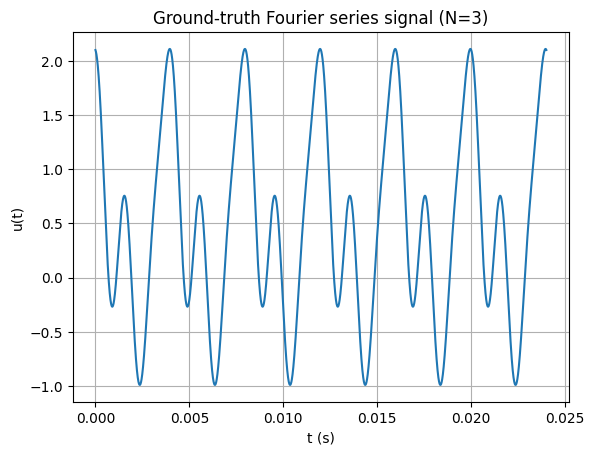

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Choose Fourier series parameters
N = 3
f = 250                 # Hz (base frequency)
omega = 2*np.pi*f        # rad/s
P = 1/f                  # period (s)

num_periods = 6
T = num_periods * P

samples_per_period = 10 * f     # samples per period is 10 times the base frequency to avoid aliasing
Nt = num_periods * samples_per_period
t = np.linspace(0, T, Nt, endpoint=False)

# Choose coefficients (arbitrary)
a0 = 0.5
a = np.array([1.0, 0.4, 0.2])     # a1, a2, a3
b = np.array([0.0, -0.6, 0.3])    # b1, b2, b3

# Build u(t)
u = a0 * np.ones_like(t)
for i in range(1, N+1):
    u += a[i-1]*np.cos(i*omega*t) + b[i-1]*np.sin(i*omega*t)

# Plot ground-truth signal
plt.figure()
plt.plot(t, u)
plt.xlabel("t (s)")
plt.ylabel("u(t)")
plt.title("Ground-truth Fourier series signal (N=3)")
plt.grid(True)
plt.show()

## (a) Now imagine you are an experimentalist collecting u(t) data but you cannot measure u(t) at high resolution. You can only collect p points with p sensors where p is not a very large number (if you just plot this data with these p measurements your curve will look terrible compared to ground truth). Use compressed sensing (maybe discrete cosine transform as your sparsifying transform) to reconstruct high resolution data (same resolution as ground-truth) based on your p measurements. How low can you make p and still get good results? How does this depend on the frequency of your signal (if you make frequency higher do you need more sensors?) Please show all of your results and discuss your findings.


=== Frequency f=50.0 Hz ===
n = 360 samples, fs = 3000.0 Hz, T = 0.120000 s
Smallest p achieving rel error <= 0.050: p = 90

=== Frequency f=150.0 Hz ===
n = 360 samples, fs = 9000.0 Hz, T = 0.040000 s
Smallest p achieving rel error <= 0.050: p = 90

=== Frequency f=250.0 Hz ===
n = 360 samples, fs = 15000.0 Hz, T = 0.024000 s
Smallest p achieving rel error <= 0.050: p = 80

=== Frequency f=1000.0 Hz ===
n = 360 samples, fs = 60000.0 Hz, T = 0.006000 s
Smallest p achieving rel error <= 0.050: p = 100

=== Frequency f=10000.0 Hz ===
n = 361 samples, fs = 600000.0 Hz, T = 0.000600 s
Smallest p achieving rel error <= 0.050: p = 80


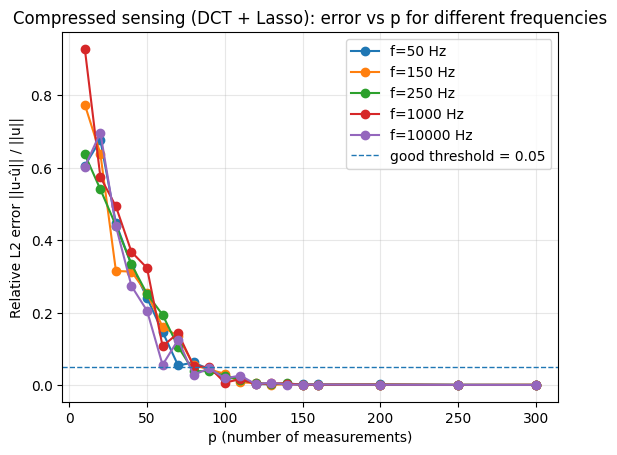

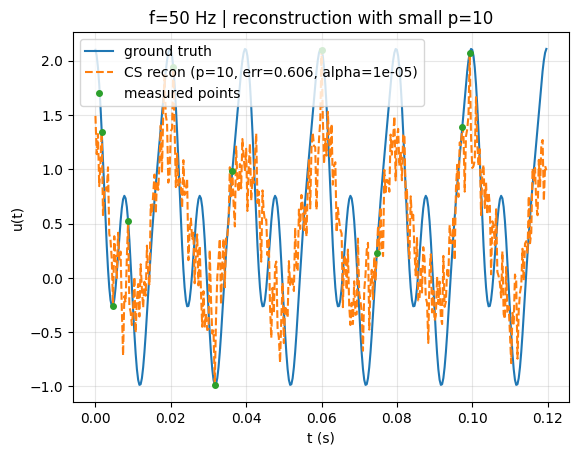

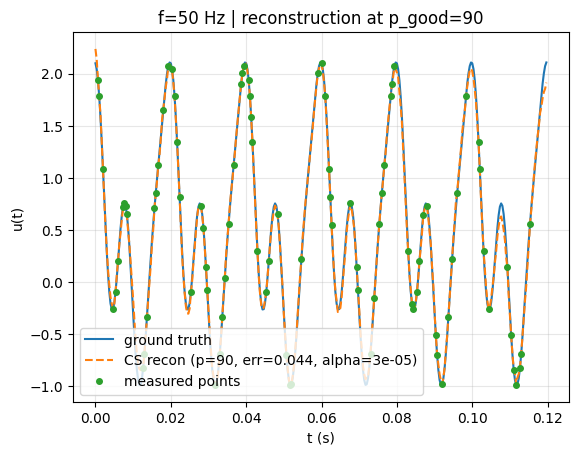

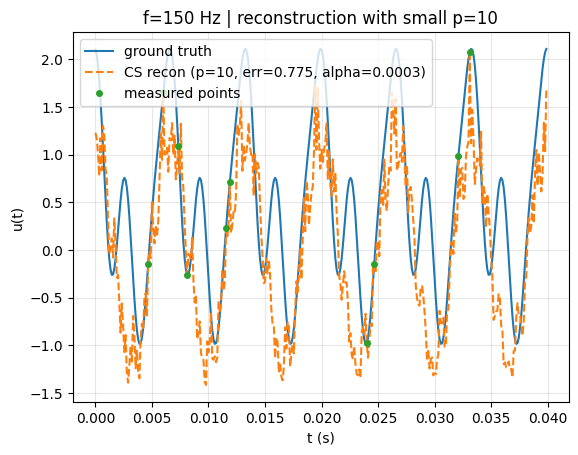

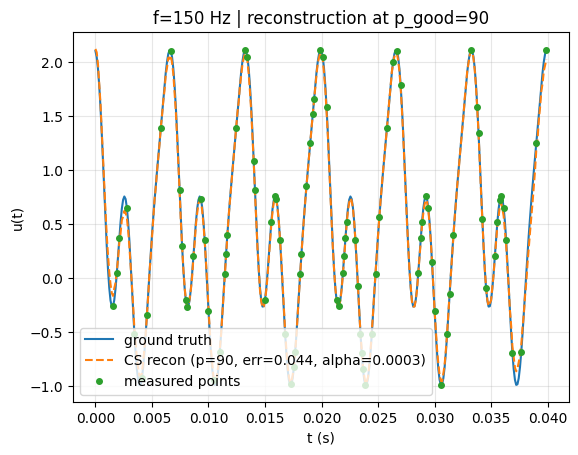

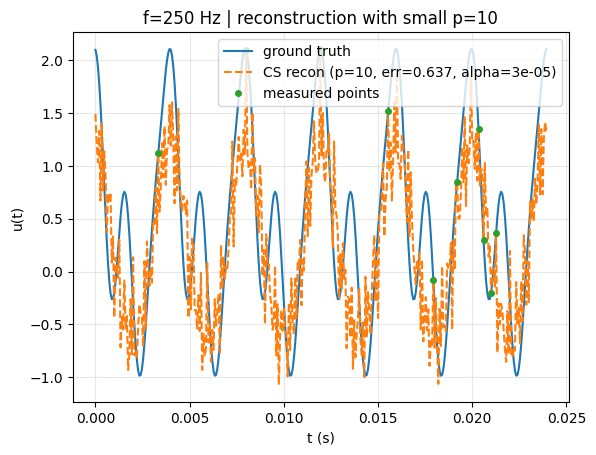

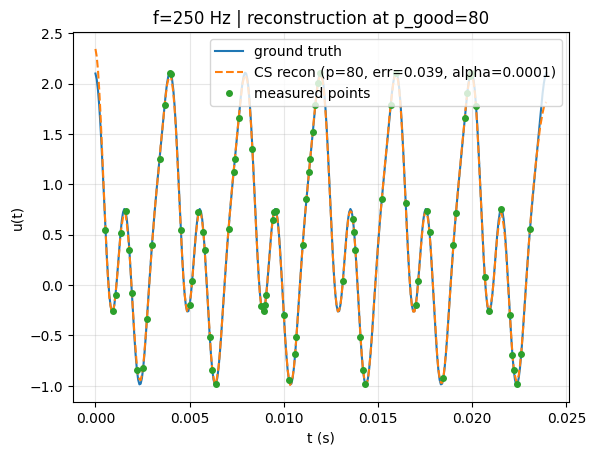

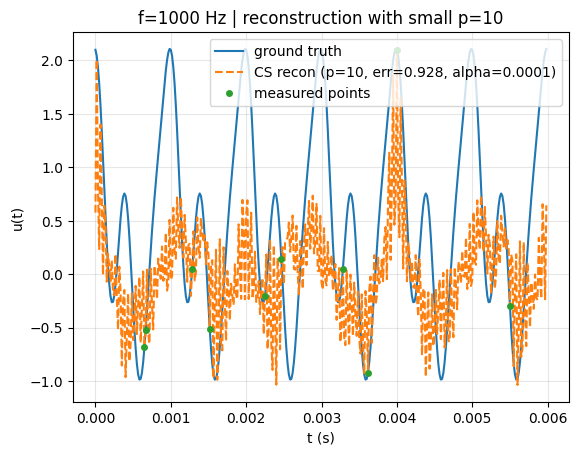

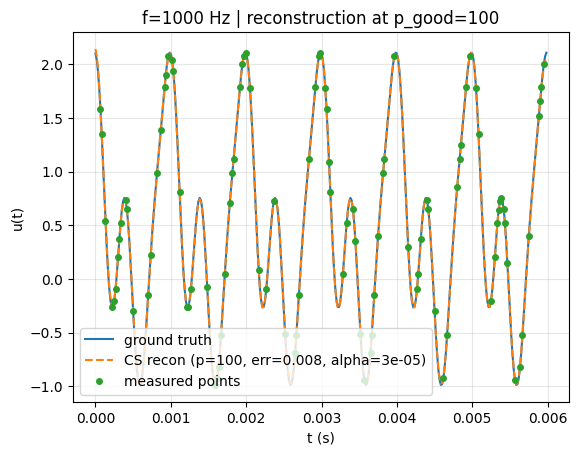

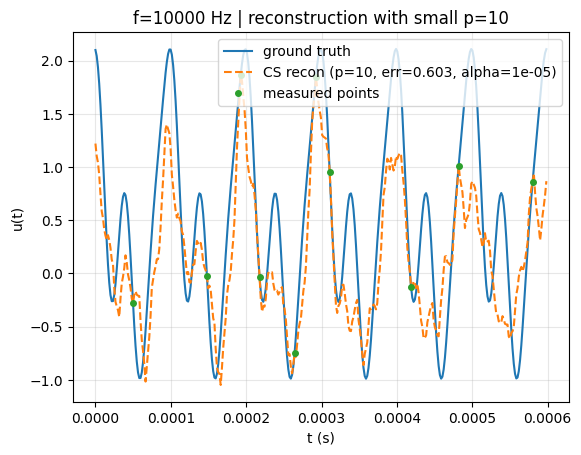

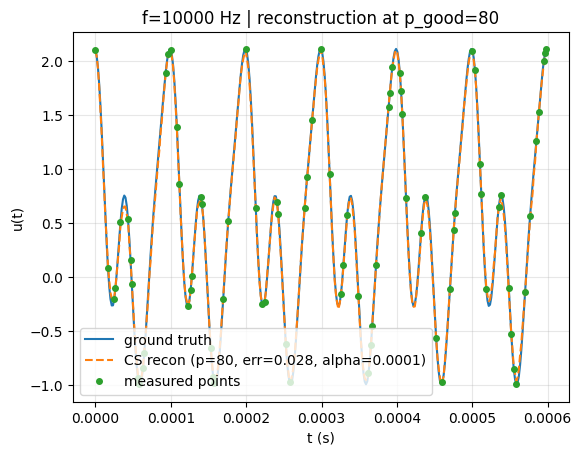

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import idct
from sklearn.linear_model import Lasso

# user configs
N = 3                         # number of harmonics in ground-truth Fourier series
freqs_hz = [50.0, 150.0, 250.0, 1000, 10000]  # test several base frequencies to see dependence of error on frequency
num_periods = 6               # number of periods included in the time window
oversample = 20               # sampling rate multiplier relative to highest harmonic (N*f)
seed = 0                      # reproducible randomness

# "Good results" threshold (relative L2 error)
good_rel_err = 0.05           # 5% relative error

# Sweep p (number of measurements / sensors)
# Note: n = len(u) changes with frequency
p_candidates = list(range(10, 161, 10)) + [200, 250, 300]

# Lasso strength candidates
alpha_candidates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]

# Helper functions
def build_fourier_signal(f_hz, N, num_periods, oversample, a0, a, b):
    omega = 2.0 * np.pi * f_hz
    P = 1.0 / f_hz
    T = num_periods * P

    # Highest harmonic frequency is N*f; choose fs = oversample*(N*f)
    fs = oversample * (N * f_hz)
    n = int(np.ceil(T * fs))
    t = np.linspace(0, T, n, endpoint=False)

    u = a0 * np.ones_like(t)
    for i in range(1, N + 1):
        u += a[i - 1] * np.cos(i * omega * t) + b[i - 1] * np.sin(i * omega * t)
    return t, u, fs

def rel_l2_error(u_true, u_hat):
    num = np.linalg.norm(u_true - u_hat)
    den = np.linalg.norm(u_true) + 1e-12
    return num / den

def cs_reconstruct_dct_lasso(u_true, p, alpha, rng):
    """
    Reconstruct u_true (length n) from p random samples using DCT basis and Lasso.

    Model:
      u = Psi c   where Psi is the inverse-DCT basis matrix (orthonormal),
      y = u[idx] = (Psi[idx,:]) c
      Solve: min_c ||A c - y||_2^2 + alpha * ||c||_1
    """
    n = u_true.size
    idx = np.sort(rng.choice(n, size=p, replace=False))
    y = u_true[idx]

    # Build inverse-DCT basis matrix Psi efficiently: Psi = idct(I)
    # Psi is (n,n) and orthonormal when norm='ortho'
    Psi = idct(np.eye(n), norm='ortho', axis=0)  # columns are basis vectors in time domain

    A = Psi[idx, :]  # (p,n)

    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000)
    model.fit(A, y)
    c_hat = model.coef_
    u_hat = Psi @ c_hat
    return idx, y, u_hat

# Ground-truth coefficients (arbitrary, but fixed across tests)
a0 = 0.5
a = np.array([1.0, 0.4, 0.2])      # a1,a2,a3
b = np.array([0.0, -0.6, 0.3])     # b1,b2,b3

rng = np.random.default_rng(seed)

results = {}  # results[f] = dict with errors, best reconstructions, etc.

for f in freqs_hz:
    t, u, fs = build_fourier_signal(f, N, num_periods, oversample, a0, a, b)
    n = len(u)
    p_list = [p for p in p_candidates if p < n]  # ensure p < n

    errs = []
    best_alpha_used = []
    best_recons = {}  # best_recons[p] = (idx, y, u_hat, err)

    for p in p_list:
        best_err = np.inf
        best_pack = None
        # Try multiple alphas and pick the best for this (f,p)
        for alpha in alpha_candidates:
            idx, y, u_hat = cs_reconstruct_dct_lasso(u, p, alpha, rng)
            err = rel_l2_error(u, u_hat)
            if err < best_err:
                best_err = err
                best_pack = (idx, y, u_hat, err, alpha)
        errs.append(best_err)
        best_alpha_used.append(best_pack[4])
        best_recons[p] = best_pack

    # find minimum p achieving "good"
    p_good = None
    for p, e in zip(p_list, errs):
        if e <= good_rel_err:
            p_good = p
            break

    results[f] = {
        "t": t, "u": u, "fs": fs, "n": n,
        "p_list": p_list, "errs": np.array(errs),
        "best_alpha": np.array(best_alpha_used),
        "best_recons": best_recons,
        "p_good": p_good
    }

    print(f"\n=== Frequency f={f:.1f} Hz ===")
    print(f"n = {n} samples, fs = {fs:.1f} Hz, T = {t[-1] + (t[1]-t[0]):.6f} s")
    if p_good is None:
        print(f"No p in your sweep achieved rel error <= {good_rel_err:.3f}. Try increasing p_candidates or tuning alpha.")
    else:
        print(f"Smallest p achieving rel error <= {good_rel_err:.3f}: p = {p_good}")


# Plot 1: Error vs p for each frequency
plt.figure()
for f in freqs_hz:
    p_list = results[f]["p_list"]
    errs = results[f]["errs"]
    plt.plot(p_list, errs, marker='o', linestyle='-', label=f"f={f:.0f} Hz")
plt.axhline(good_rel_err, linestyle='--', linewidth=1, label=f"good threshold = {good_rel_err:.2f}")
plt.xlabel("p (number of measurements)")
plt.ylabel("Relative L2 error ||u-û|| / ||u||")
plt.title("Compressed sensing (DCT + Lasso): error vs p for different frequencies")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot 2: Example reconstructions for each frequency
# Show: (i) very small p, (ii) p_good (if exists)
for f in freqs_hz:
    t = results[f]["t"]
    u = results[f]["u"]
    p_list = results[f]["p_list"]
    best_recons = results[f]["best_recons"]
    p_good = results[f]["p_good"]

    # choose a "small p" example (first in list)
    p_small = p_list[0]
    idx_s, y_s, uhat_s, err_s, alpha_s = best_recons[p_small]

    plt.figure()
    plt.plot(t, u, label="ground truth")
    plt.plot(t, uhat_s, '--', label=f"CS recon (p={p_small}, err={err_s:.3f}, alpha={alpha_s:g})")
    plt.plot(t[idx_s], y_s, 'o', markersize=4, label="measured points")
    plt.xlabel("t (s)")
    plt.ylabel("u(t)")
    plt.title(f"f={f:.0f} Hz | reconstruction with small p={p_small}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    if p_good is not None:
        idx_g, y_g, uhat_g, err_g, alpha_g = best_recons[p_good]
        plt.figure()
        plt.plot(t, u, label="ground truth")
        plt.plot(t, uhat_g, '--', label=f"CS recon (p={p_good}, err={err_g:.3f}, alpha={alpha_g:g})")
        plt.plot(t[idx_g], y_g, 'o', markersize=4, label="measured points")
        plt.xlabel("t (s)")
        plt.ylabel("u(t)")
        plt.title(f"f={f:.0f} Hz | reconstruction at p_good={p_good}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

In this experiment, I generated ground-truth signals u(t) using a truncated Fourier series with N = 3 harmonics and tested how well compressed sensing can reconstruct a full high-resolution signal when only p measurements are available. For each base frequency f in {50, 150, 250, 1000, 10000} Hz, I created a time window spanning 6 periods and sampled it at a high rate defined as fs = oversample * (N * f) = 20 * 3f. This produced about n ≈ 360 ground-truth samples for each case. To simulate limited experimental sensing, I randomly selected p time indices (without replacement) from the n available samples and treated those values as my measurements. I then reconstructed the full signal using a DCT sparsifying model (u represented as an inverse DCT basis times a coefficient vector) and solved for the sparse coefficient vector using Lasso (an L1-regularized least squares method). For each frequency and p value, I swept a small set of Lasso strength values (alpha candidates) and reported the best reconstruction error achieved across those alpha values. Reconstruction accuracy was measured using relative L2 error, defined as the L2 norm of (u minus u_hat) divided by the L2 norm of u. I defined “good” reconstruction as relative error less than or equal to 0.05 (5%).

Using this setup, the smallest p that met the 5% error threshold was typically in the range of 80 to 100 measurements depending on frequency: p = 90 for f = 50 Hz and 150 Hz, p = 80 for f = 250 Hz, p = 100 for f = 1000 Hz, and p = 80 for f = 10000 Hz. Since the full signal length was n ≈ 360, these thresholds correspond to using roughly 22% to 28% of the available samples (about a 3 to 4 times reduction in measurements) while still recovering the high-resolution waveform accurately. The dependence of required p on frequency was not strictly monotonic in these results; increasing f did not always increase the minimum p. This matches how the method works in practice: performance depends primarily on how sparse or compressible the signal is in the chosen DCT basis and on the random measurement pattern. Although the ground-truth signal is exactly sparse in a Fourier basis (only a few harmonics), it is only approximately sparse in the DCT basis, and the effective sparsity can change with frequency and with how the sinusoidal content aligns with the discrete time grid. Also, because the reconstruction used one random draw of measurement indices (with a fixed RNG seed) and selected the best alpha from a discrete candidate list, small variations in the minimum p (for example 80 vs 90 vs 100) are expected. Overall, the main takeaway is that with this DCT + Lasso compressed sensing pipeline and random sampling, the signal could be reconstructed well using on the order of about one quarter of the samples, and higher frequency did not fundamentally break reconstruction for this low-harmonic (N = 3) signal.


## (b) Now consider the data with just one period (define T to be equal to one period). Does your method still work?


=== Frequency f=50.0 Hz ===
n = 60 samples, fs = 3000.0 Hz, T = 0.020000 s
Smallest p achieving rel error <= 0.050: p = 20

=== Frequency f=150.0 Hz ===
n = 61 samples, fs = 9000.0 Hz, T = 0.006667 s
Smallest p achieving rel error <= 0.050: p = 25

=== Frequency f=250.0 Hz ===
n = 60 samples, fs = 15000.0 Hz, T = 0.004000 s
Smallest p achieving rel error <= 0.050: p = 25

=== Frequency f=1000.0 Hz ===
n = 60 samples, fs = 60000.0 Hz, T = 0.001000 s
Smallest p achieving rel error <= 0.050: p = 20

=== Frequency f=10000.0 Hz ===
n = 60 samples, fs = 600000.0 Hz, T = 0.000100 s
Smallest p achieving rel error <= 0.050: p = 25


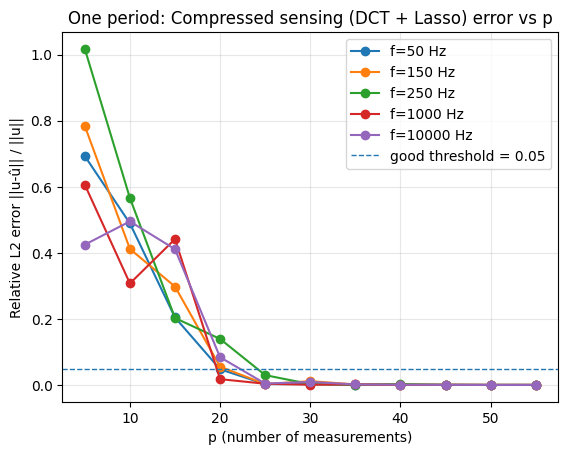

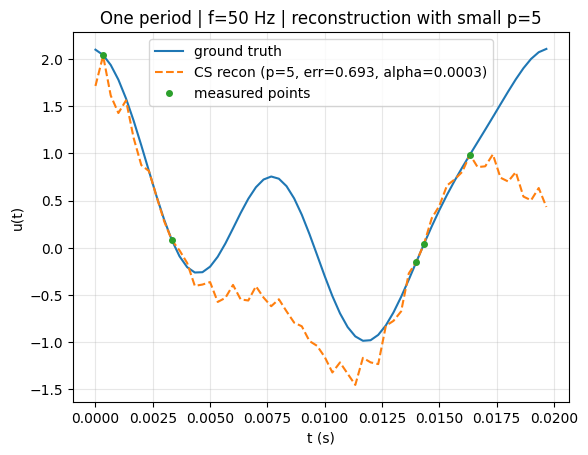

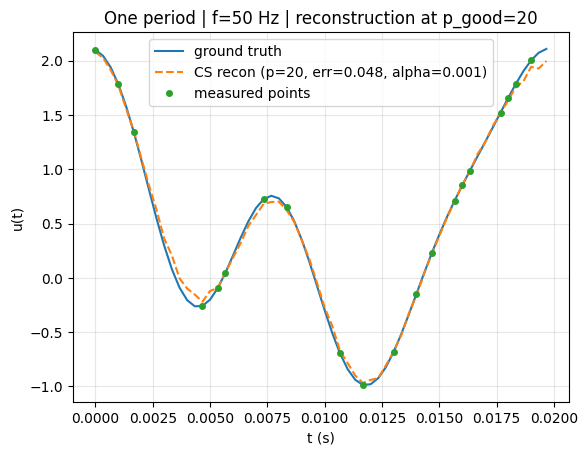

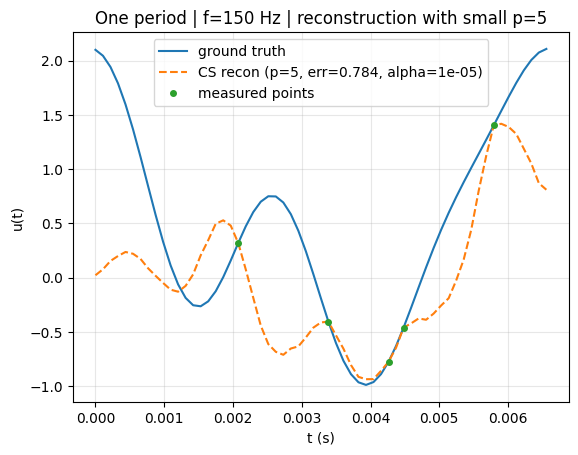

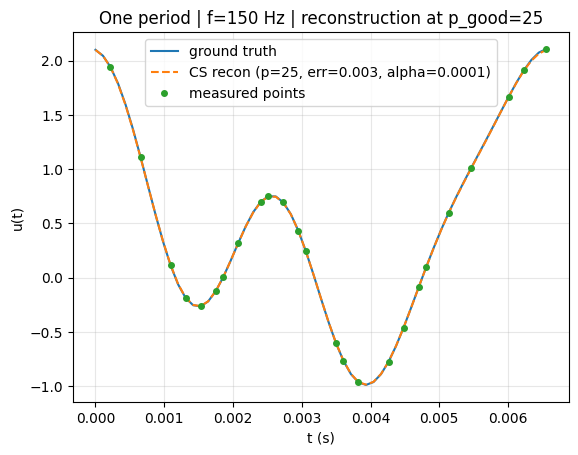

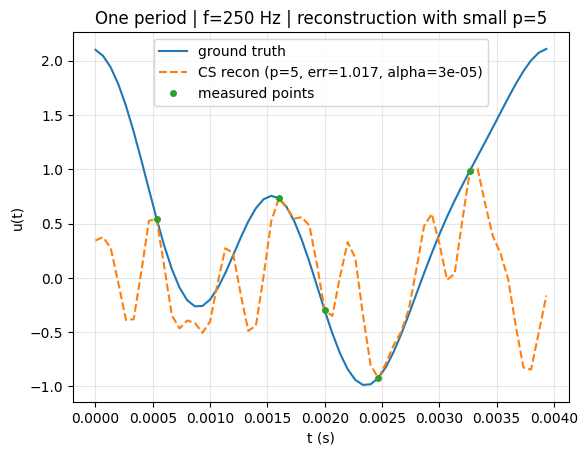

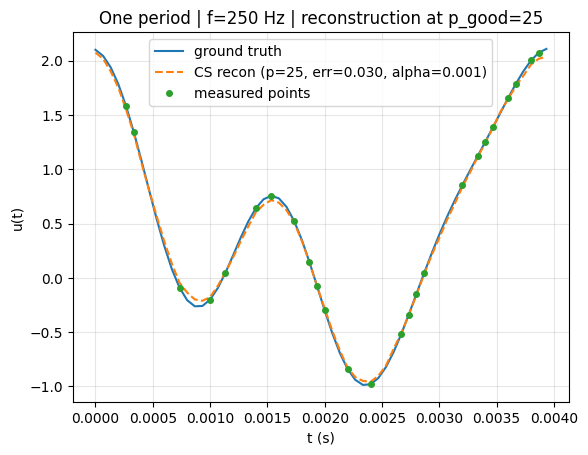

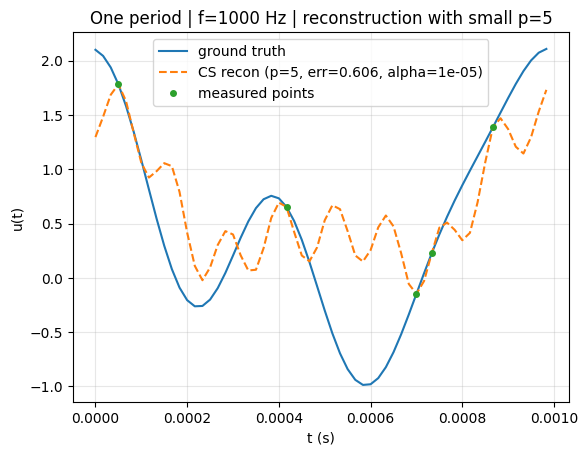

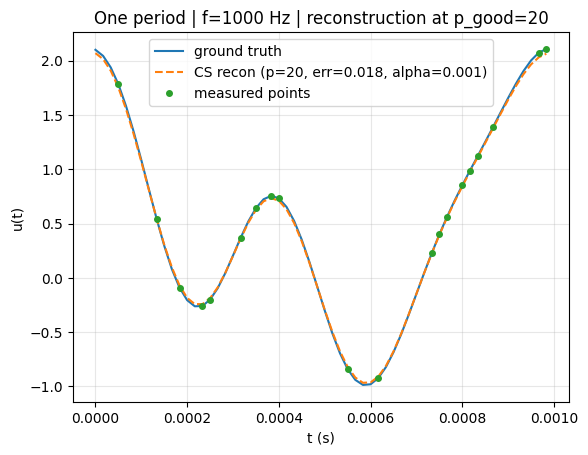

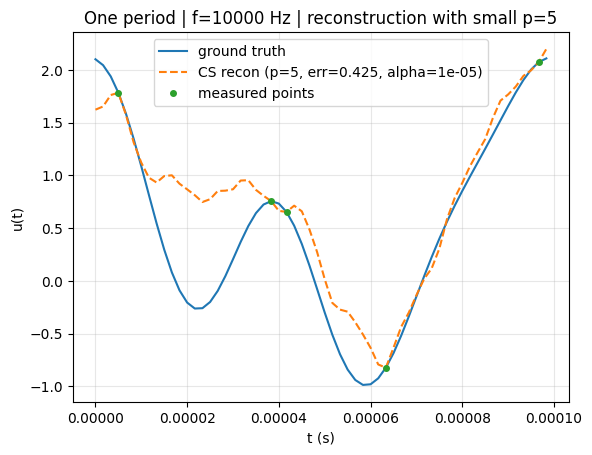

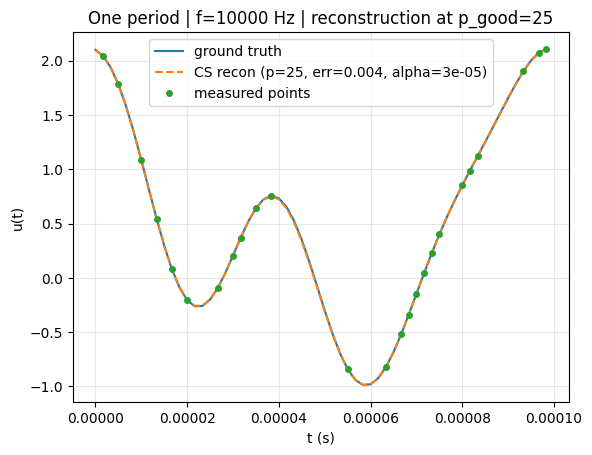

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import idct
from sklearn.linear_model import Lasso

# (b) One-period experiment: T = 1 period

# user configs
N = 3
freqs_hz = [50.0, 150.0, 250.0, 1000.0, 10000.0]
num_periods = 1               # <-- CHANGE: just ONE period
oversample = 20
seed = 0

# "Good results" threshold (relative L2 error)
good_rel_err = 0.05

# With one period, n ~ oversample * N * num_periods = 20 * 3 * 1 = 60 samples (approximately)
# So p must be less than n, and it makes sense to sweep smaller p values.
p_candidates = list(range(5, 56, 5))  # 5,10,15,...,55

# Lasso strength candidates
alpha_candidates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]

# Helper functions
def build_fourier_signal(f_hz, N, num_periods, oversample, a0, a, b):
    omega = 2.0 * np.pi * f_hz
    P = 1.0 / f_hz
    T = num_periods * P

    # Highest harmonic frequency is N*f; choose fs = oversample*(N*f)
    fs = oversample * (N * f_hz)
    n = int(np.ceil(T * fs))
    t = np.linspace(0, T, n, endpoint=False)

    u = a0 * np.ones_like(t)
    for i in range(1, N + 1):
        u += a[i - 1] * np.cos(i * omega * t) + b[i - 1] * np.sin(i * omega * t)
    return t, u, fs

def rel_l2_error(u_true, u_hat):
    num = np.linalg.norm(u_true - u_hat)
    den = np.linalg.norm(u_true) + 1e-12
    return num / den

def cs_reconstruct_dct_lasso(u_true, p, alpha, rng):
    n = u_true.size
    idx = np.sort(rng.choice(n, size=p, replace=False))
    y = u_true[idx]

    # Inverse-DCT basis matrix Psi: u = Psi c
    Psi = idct(np.eye(n), norm='ortho', axis=0)
    A = Psi[idx, :]

    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000)
    model.fit(A, y)

    c_hat = model.coef_
    u_hat = Psi @ c_hat
    return idx, y, u_hat

# Ground-truth coefficients
a0 = 0.5
a = np.array([1.0, 0.4, 0.2])
b = np.array([0.0, -0.6, 0.3])

rng = np.random.default_rng(seed)
results = {}

for f in freqs_hz:
    t, u, fs = build_fourier_signal(f, N, num_periods, oversample, a0, a, b)
    n = len(u)
    p_list = [p for p in p_candidates if p < n]

    errs = []
    best_alpha_used = []
    best_recons = {}

    for p in p_list:
        best_err = np.inf
        best_pack = None

        for alpha in alpha_candidates:
            idx, y, u_hat = cs_reconstruct_dct_lasso(u, p, alpha, rng)
            err = rel_l2_error(u, u_hat)
            if err < best_err:
                best_err = err
                best_pack = (idx, y, u_hat, err, alpha)

        errs.append(best_err)
        best_alpha_used.append(best_pack[4])
        best_recons[p] = best_pack

    p_good = None
    for p, e in zip(p_list, errs):
        if e <= good_rel_err:
            p_good = p
            break

    results[f] = {
        "t": t, "u": u, "fs": fs, "n": n,
        "p_list": p_list, "errs": np.array(errs),
        "best_alpha": np.array(best_alpha_used),
        "best_recons": best_recons,
        "p_good": p_good
    }

    print(f"\n=== Frequency f={f:.1f} Hz ===")
    print(f"n = {n} samples, fs = {fs:.1f} Hz, T = {t[-1] + (t[1]-t[0]):.6f} s")
    if p_good is None:
        print(f"No p achieved rel error <= {good_rel_err:.3f} in this sweep.")
    else:
        print(f"Smallest p achieving rel error <= {good_rel_err:.3f}: p = {p_good}")

# Plot 1: Error vs p for each frequency
plt.figure()
for f in freqs_hz:
    p_list = results[f]["p_list"]
    errs = results[f]["errs"]
    plt.plot(p_list, errs, marker='o', linestyle='-', label=f"f={f:.0f} Hz")
plt.axhline(good_rel_err, linestyle='--', linewidth=1, label=f"good threshold = {good_rel_err:.2f}")
plt.xlabel("p (number of measurements)")
plt.ylabel("Relative L2 error ||u-û|| / ||u||")
plt.title("One period: Compressed sensing (DCT + Lasso) error vs p")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot 2: Example reconstructions for each frequency (small p and p_good if exists)
for f in freqs_hz:
    t = results[f]["t"]
    u = results[f]["u"]
    p_list = results[f]["p_list"]
    best_recons = results[f]["best_recons"]
    p_good = results[f]["p_good"]

    p_small = p_list[0]
    idx_s, y_s, uhat_s, err_s, alpha_s = best_recons[p_small]

    plt.figure()
    plt.plot(t, u, label="ground truth")
    plt.plot(t, uhat_s, '--', label=f"CS recon (p={p_small}, err={err_s:.3f}, alpha={alpha_s:g})")
    plt.plot(t[idx_s], y_s, 'o', markersize=4, label="measured points")
    plt.xlabel("t (s)")
    plt.ylabel("u(t)")
    plt.title(f"One period | f={f:.0f} Hz | reconstruction with small p={p_small}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    if p_good is not None:
        idx_g, y_g, uhat_g, err_g, alpha_g = best_recons[p_good]
        plt.figure()
        plt.plot(t, u, label="ground truth")
        plt.plot(t, uhat_g, '--', label=f"CS recon (p={p_good}, err={err_g:.3f}, alpha={alpha_g:g})")
        plt.plot(t[idx_g], y_g, 'o', markersize=4, label="measured points")
        plt.xlabel("t (s)")
        plt.ylabel("u(t)")
        plt.title(f"One period | f={f:.0f} Hz | reconstruction at p_good={p_good}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

In this one-period experiment, the total time window T was set to exactly one period (T = 1/f), and the “high-resolution” sampling rate was chosen as fs = oversample * (N * f) with oversample = 20 and N = 3. Because T decreases as 1/f while fs increases proportionally with f, the total number of high-resolution samples n = T * fs stays approximately constant across frequencies (about 60 samples in every case). That is why you see n = 60 or 61 for all tested frequencies even though the total time window becomes much shorter at higher frequencies. In other words, higher frequency does not automatically give you fewer ground-truth samples in this specific setup, because the sampling rate increases to compensate.

The reconstruction results show that the compressed sensing approach still works with only a single period, but you need a moderate fraction of the full samples to achieve the same 5% relative error threshold. Specifically, the smallest p values that achieved the error target were in the range of 20 to 25 measurements out of n ≈ 60, which corresponds to using roughly 33% to 42% of the available samples. Compared to the earlier 6-period case (where n was about 360 and p_good was about 80 to 100, or roughly 22% to 28%), the one-period case requires a larger percentage of samples. This makes sense because with only one period there is less repeated temporal structure available in the dataset, so the reconstruction has less information to “average out” and can be more sensitive to which specific time points are measured. The slight variation in p_good across frequencies (20 vs 25) is not strongly monotonic and is expected here due to discretization effects, basis mismatch (using DCT rather than a Fourier basis), and the random choice of measurement indices; small changes in how the sinusoidal waveform lines up with the discrete grid can change how sparse/compressible the signal appears in the DCT basis and therefore shift the minimum p needed for good reconstruction.

## (c) Now add noise to your signal in part (a) similar to last example. How robust are your results based on the level of noise? Implement the optimization formulation we discussed in class that is more robust to noise to see how that improves your results.


=== f=50.0 Hz, noise zeta=0.00 ===
n=360 samples, fs=3000.0 Hz, T=0.120000 s
LASSO: smallest p with rel err <= 0.050: 70
BPDN (epsilon): smallest p with rel err <= 0.050: 90

=== f=50.0 Hz, noise zeta=0.05 ===
n=360 samples, fs=3000.0 Hz, T=0.120000 s
LASSO: smallest p with rel err <= 0.050: 120
BPDN (epsilon): smallest p with rel err <= 0.050: 140

=== f=50.0 Hz, noise zeta=0.10 ===
n=360 samples, fs=3000.0 Hz, T=0.120000 s
LASSO: smallest p with rel err <= 0.050: None
BPDN (epsilon): smallest p with rel err <= 0.050: None

=== f=50.0 Hz, noise zeta=0.20 ===
n=360 samples, fs=3000.0 Hz, T=0.120000 s
LASSO: smallest p with rel err <= 0.050: None
BPDN (epsilon): smallest p with rel err <= 0.050: None

=== f=150.0 Hz, noise zeta=0.00 ===
n=360 samples, fs=9000.0 Hz, T=0.040000 s
LASSO: smallest p with rel err <= 0.050: 90
BPDN (epsilon): smallest p with rel err <= 0.050: 90

=== f=150.0 Hz, noise zeta=0.05 ===
n=360 samples, fs=9000.0 Hz, T=0.040000 s
LASSO: smallest p with rel err <= 0

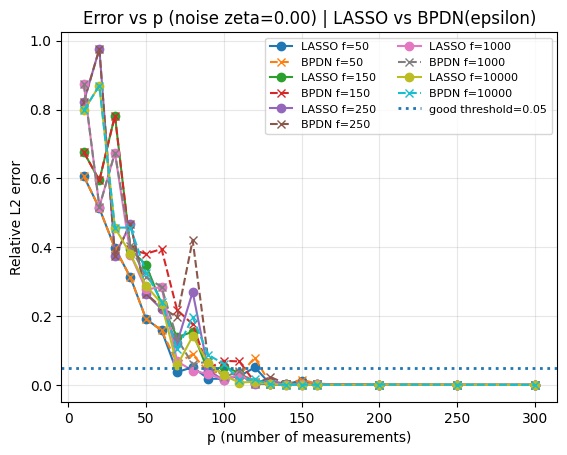

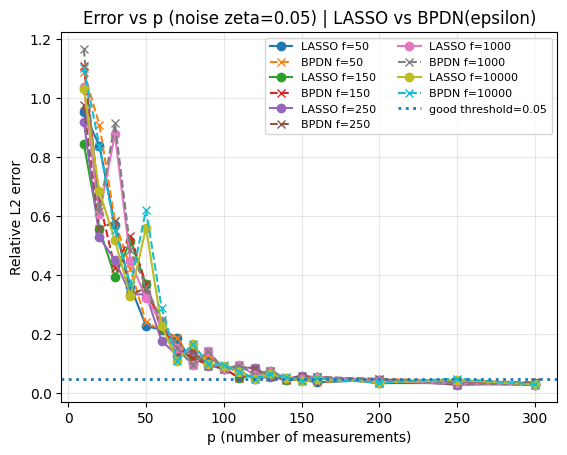

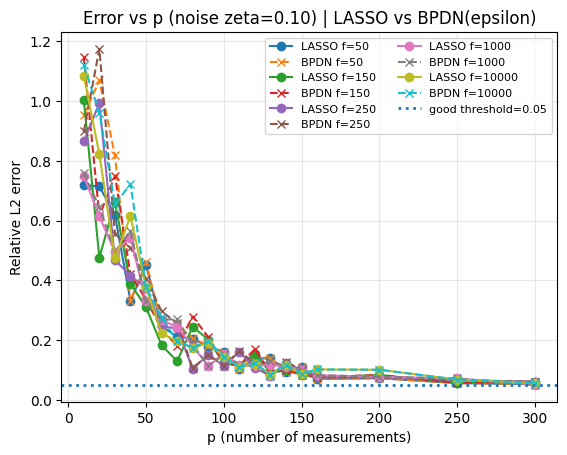

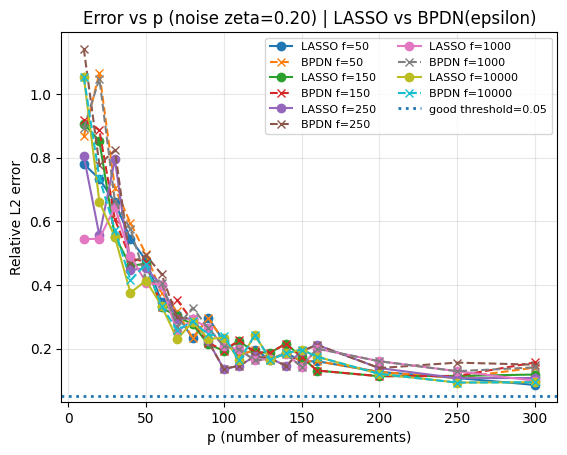

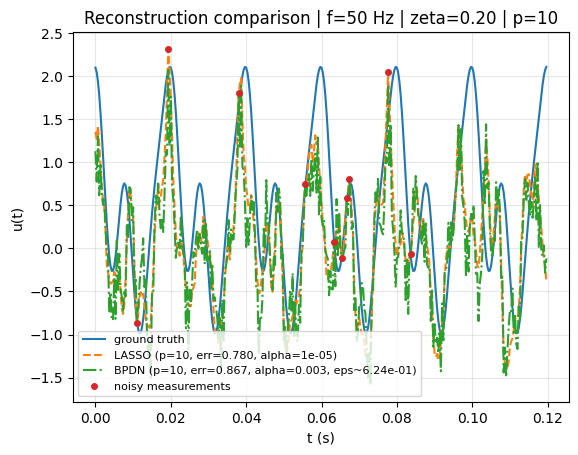

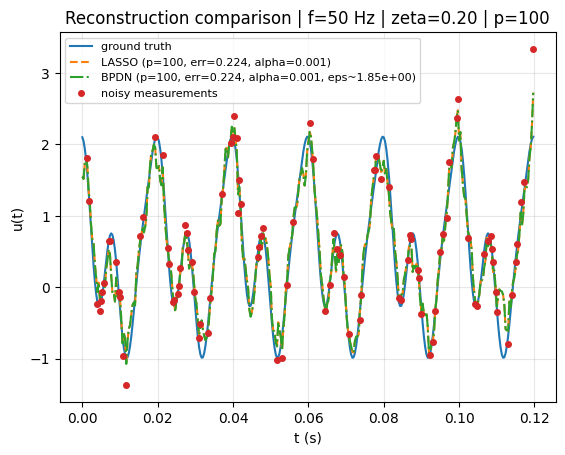

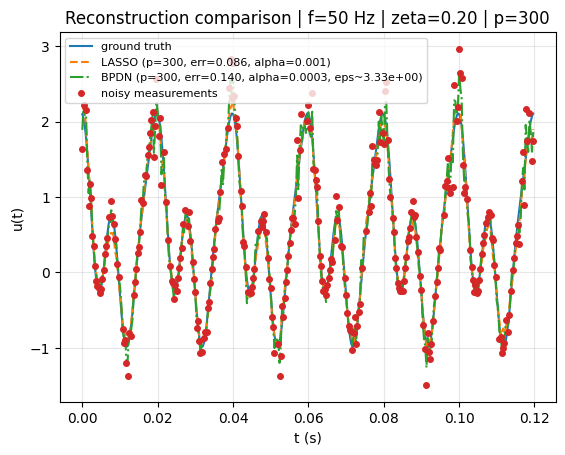

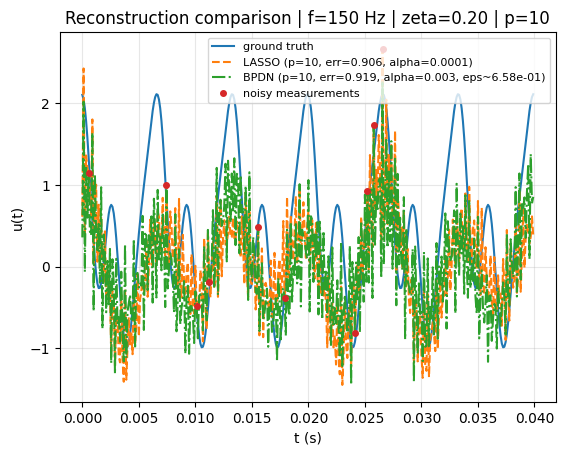

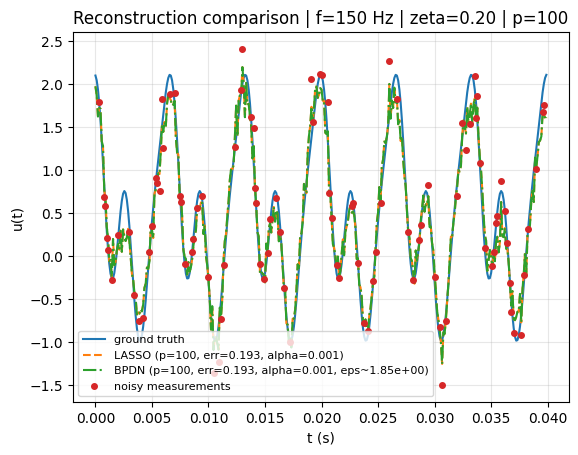

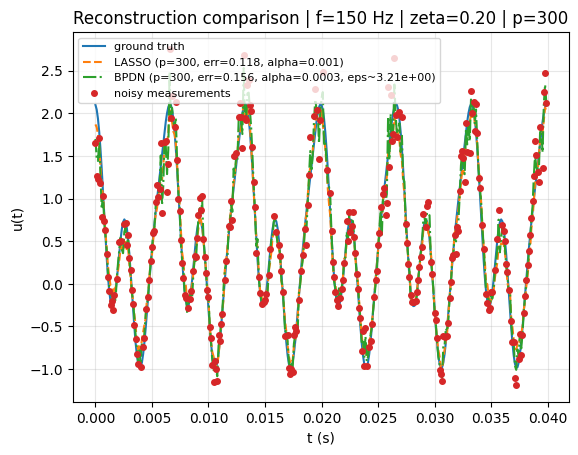

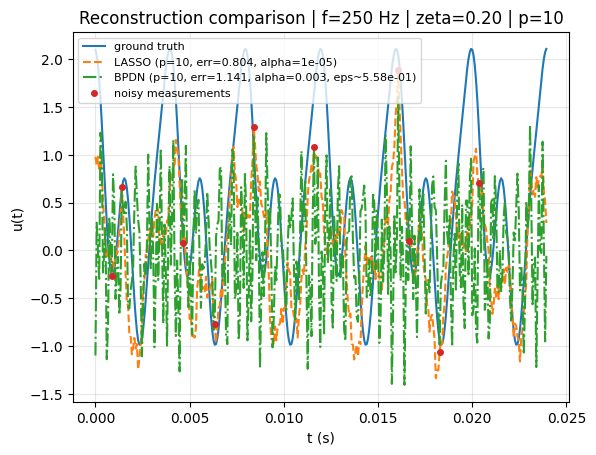

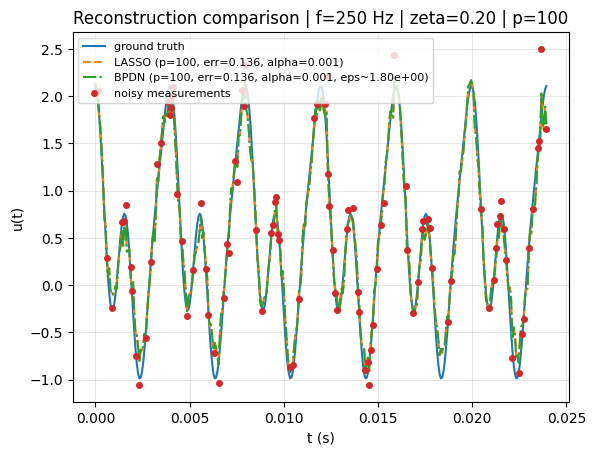

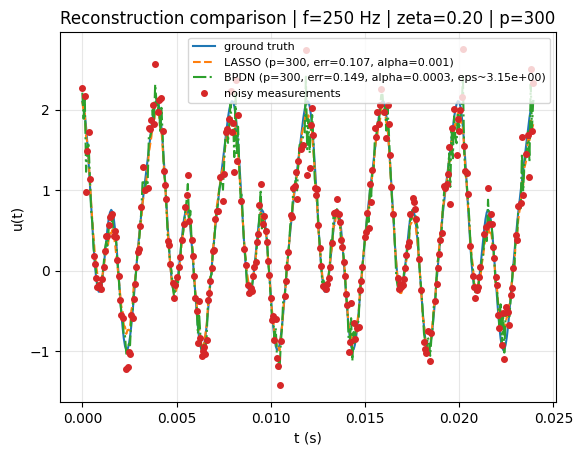

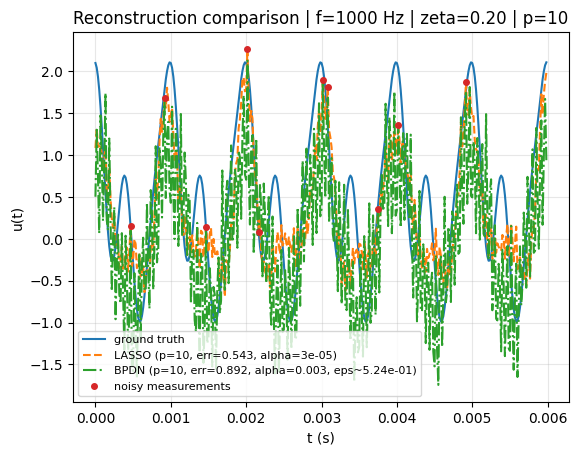

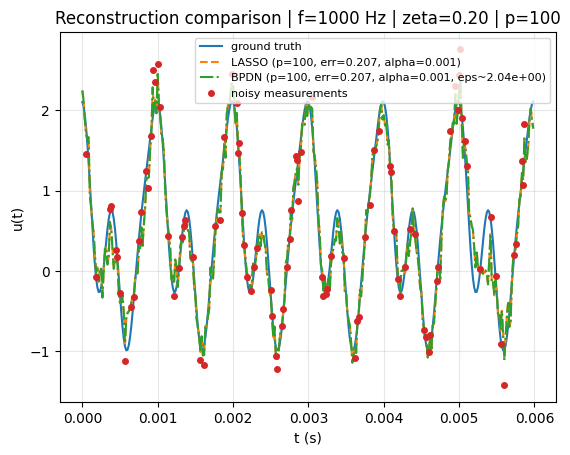

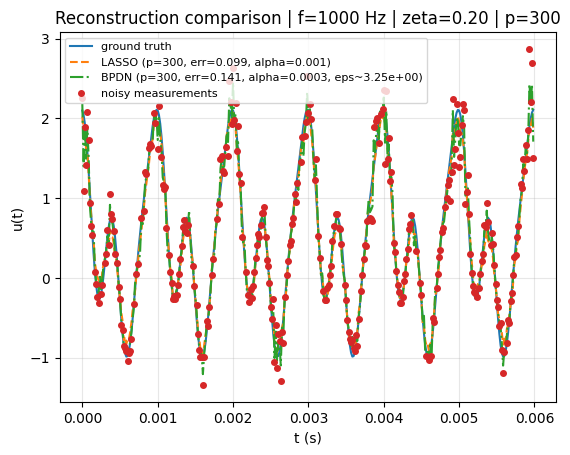

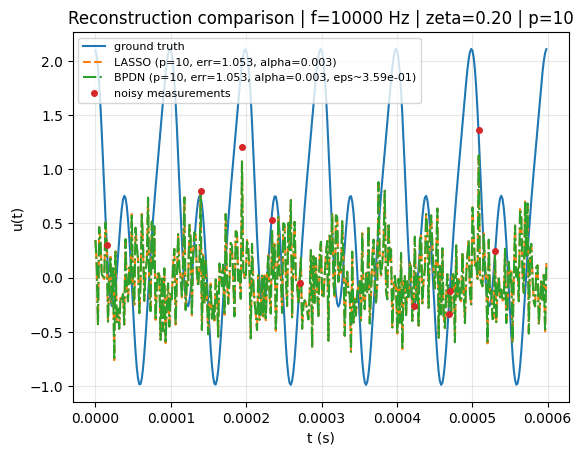

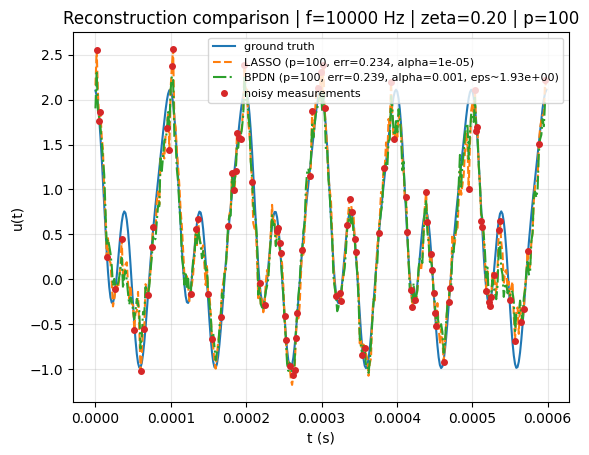

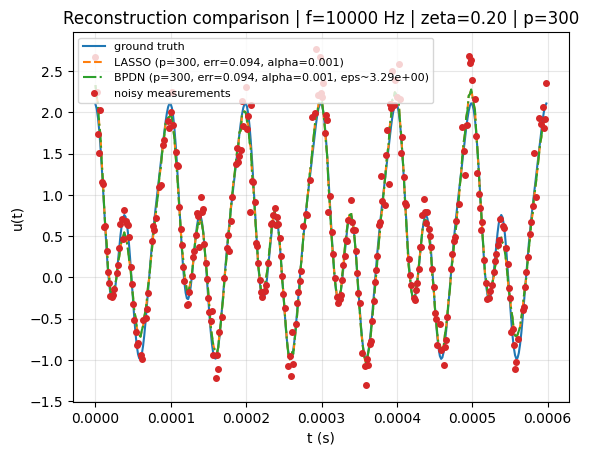

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import idct
from sklearn.linear_model import Lasso

# -----------------------------
# USER CONFIGS
# -----------------------------
N = 3
freqs_hz = [50.0, 150.0, 250.0, 1000.0, 10000.0]   # signal base frequencies
num_periods = 6
oversample = 20
seed = 0

# noise levels to test (multiplicative)
zetas = [0.0, 0.05, 0.10, 0.20]   # 0.0 included for baseline comparison

# "Good results" threshold (relative L2 error)
good_rel_err = 0.05

# Sweep p (number of measurements)
p_candidates = list(range(10, 161, 10)) + [200, 250, 300]

# Lasso alpha candidates (for both methods)
alpha_candidates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]

# Choose epsilon rule: epsilon = eps_mult * sqrt(p) * sigma_est
# where sigma_est is estimated from noisy measurements (multiplicative model uses sigma ~ zeta * std(|y|))
eps_mult = 1.0

# -----------------------------
# Helper functions
# -----------------------------
def build_fourier_signal(f_hz, N, num_periods, oversample, a0, a, b):
    omega = 2.0 * np.pi * f_hz
    P = 1.0 / f_hz
    T = num_periods * P

    # fs = oversample * (N*f)
    fs = oversample * (N * f_hz)
    n = int(np.ceil(T * fs))
    t = np.linspace(0, T, n, endpoint=False)

    u = a0 * np.ones_like(t)
    for i in range(1, N + 1):
        u += a[i - 1] * np.cos(i * omega * t) + b[i - 1] * np.sin(i * omega * t)
    return t, u, fs

def rel_l2_error(u_true, u_hat):
    return np.linalg.norm(u_true - u_hat) / (np.linalg.norm(u_true) + 1e-12)

def make_measurements(u_true, p, rng):
    n = u_true.size
    idx = np.sort(rng.choice(n, size=p, replace=False))
    y = u_true[idx]
    return idx, y

def add_multiplicative_noise(y, zeta, rng):
    # y_noisy = y + zeta * rand * y, rand ~ N(0,1)
    if zeta == 0.0:
        return y.copy()
    rand = rng.standard_normal(size=y.shape)
    return y + zeta * rand * y

def build_dct_basis(n):
    # Psi is inverse-DCT basis, orthonormal with norm='ortho'
    return idct(np.eye(n), norm='ortho', axis=0)

def lasso_solve(A, y_noisy, alpha):
    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000)
    model.fit(A, y_noisy)
    s_hat = model.coef_
    return s_hat

def epsilon_from_noisy_y(y_noisy, p, zeta, eps_mult=1.0):
    """
    Heuristic for epsilon. For additive noise with std sigma:
      epsilon ~ sqrt(p)*sigma
    Here noise is multiplicative: y_noisy = y*(1 + zeta*rand)
    so std(noise) ~ zeta * std(|y|) (rough heuristic).
    """
    if zeta == 0.0:
        return 0.0
    sigma_est = zeta * (np.std(y_noisy) + 1e-12)
    return eps_mult * np.sqrt(p) * sigma_est

def bpdn_via_lasso_path(A, y_noisy, Psi, alpha_list, epsilon):
    """
    Approximate BPDN:
      minimize ||s||_1  subject to ||A s - y||_2 <= epsilon

    We compute multiple Lasso solutions across alpha_list and select:
      - among solutions with residual <= epsilon, choose the one with smallest L1 norm
      - if none satisfy residual<=epsilon, choose the one with smallest residual (best fit)
    """
    best_s = None
    best_u = None
    best_res = None
    best_l1 = None
    best_alpha = None

    any_feasible = False

    for alpha in alpha_list:
        s_hat = lasso_solve(A, y_noisy, alpha)
        r = A @ s_hat - y_noisy
        res = np.linalg.norm(r, 2)
        l1 = np.linalg.norm(s_hat, 1)
        u_hat = Psi @ s_hat

        if res <= epsilon + 1e-12:
            any_feasible = True
            # pick smallest L1 among feasible solutions
            if (best_l1 is None) or (l1 < best_l1):
                best_s, best_u, best_res, best_l1, best_alpha = s_hat, u_hat, res, l1, alpha
        else:
            # if no feasible found yet, track smallest residual
            if not any_feasible:
                if (best_res is None) or (res < best_res):
                    best_s, best_u, best_res, best_l1, best_alpha = s_hat, u_hat, res, l1, alpha

    return best_u, best_alpha, best_res, best_l1, any_feasible

# -----------------------------
# Ground-truth coefficients
# -----------------------------
a0 = 0.5
a = np.array([1.0, 0.4, 0.2])
b = np.array([0.0, -0.6, 0.3])

rng = np.random.default_rng(seed)

# Store results for summaries
# results[(f, zeta)] = dict with p_list, err curves, p_good for each method, etc.
results = {}

for f in freqs_hz:
    t, u_true, fs = build_fourier_signal(f, N, num_periods, oversample, a0, a, b)
    n = len(u_true)

    # Precompute Psi once per frequency (depends on n)
    Psi = build_dct_basis(n)

    # clip p list to < n
    p_list = [p for p in p_candidates if p < n]

    for zeta in zetas:
        errs_lasso = []
        errs_bpdn = []
        best_alpha_lasso = []
        best_alpha_bpdn = []

        # track p_good
        p_good_lasso = None
        p_good_bpdn = None

        # For example recon plots
        example_pack = {}  # keys: p -> packs

        for p in p_list:
            idx, y = make_measurements(u_true, p, rng)
            y_noisy = add_multiplicative_noise(y, zeta, rng)

            # A = C Psi = Psi rows at idx
            A = Psi[idx, :]

            # -------- Method 1: Unconstrained (Lasso) --------
            # Choose best alpha by minimizing error vs ground truth (allowed in homework experiment)
            best_err = np.inf
            best_u_hat = None
            best_a = None
            for alpha in alpha_candidates:
                s_hat = lasso_solve(A, y_noisy, alpha)
                u_hat = Psi @ s_hat
                err = rel_l2_error(u_true, u_hat)
                if err < best_err:
                    best_err = err
                    best_u_hat = u_hat
                    best_a = alpha

            errs_lasso.append(best_err)
            best_alpha_lasso.append(best_a)

            # -------- Method 2: Constrained (epsilon) --------
            eps = epsilon_from_noisy_y(y_noisy, p, zeta, eps_mult=eps_mult)
            u_hat_bpdn, alpha_bpdn, res_bpdn, l1_bpdn, feasible = bpdn_via_lasso_path(
                A, y_noisy, Psi, alpha_candidates, eps
            )
            err_bpdn = rel_l2_error(u_true, u_hat_bpdn)
            errs_bpdn.append(err_bpdn)
            best_alpha_bpdn.append(alpha_bpdn)

            # Save an example reconstruction pack for plotting later
            # store only for a few p's to avoid huge memory usage
            if p in [p_list[0], p_list[len(p_list)//2], p_list[-1]]:
                example_pack[p] = {
                    "idx": idx, "y_noisy": y_noisy,
                    "u_hat_lasso": best_u_hat, "alpha_lasso": best_a, "err_lasso": best_err,
                    "u_hat_bpdn": u_hat_bpdn, "alpha_bpdn": alpha_bpdn, "err_bpdn": err_bpdn,
                    "eps": eps
                }

        errs_lasso = np.array(errs_lasso)
        errs_bpdn = np.array(errs_bpdn)

        # Determine smallest p achieving "good" error for each method
        for p, e in zip(p_list, errs_lasso):
            if e <= good_rel_err:
                p_good_lasso = p
                break
        for p, e in zip(p_list, errs_bpdn):
            if e <= good_rel_err:
                p_good_bpdn = p
                break

        results[(f, zeta)] = {
            "t": t, "u_true": u_true, "fs": fs, "n": n,
            "p_list": p_list,
            "errs_lasso": errs_lasso,
            "errs_bpdn": errs_bpdn,
            "best_alpha_lasso": best_alpha_lasso,
            "best_alpha_bpdn": best_alpha_bpdn,
            "p_good_lasso": p_good_lasso,
            "p_good_bpdn": p_good_bpdn,
            "examples": example_pack
        }

        print(f"\n=== f={f:.1f} Hz, noise zeta={zeta:.2f} ===")
        print(f"n={n} samples, fs={fs:.1f} Hz, T={(t[1]-t[0])*n:.6f} s")
        print(f"LASSO: smallest p with rel err <= {good_rel_err:.3f}: {p_good_lasso}")
        print(f"BPDN (epsilon): smallest p with rel err <= {good_rel_err:.3f}: {p_good_bpdn}")

# ------------------------------------------------------------
# PLOTS: Error vs p curves for each frequency & noise level
# ------------------------------------------------------------
for zeta in zetas:
    plt.figure()
    for f in freqs_hz:
        key = (f, zeta)
        p_list = results[key]["p_list"]
        plt.plot(p_list, results[key]["errs_lasso"], marker='o', linestyle='-', label=f"LASSO f={f:.0f}")
        plt.plot(p_list, results[key]["errs_bpdn"], marker='x', linestyle='--', label=f"BPDN f={f:.0f}")
    plt.axhline(good_rel_err, linestyle=':', linewidth=2, label=f"good threshold={good_rel_err:.2f}")
    plt.xlabel("p (number of measurements)")
    plt.ylabel("Relative L2 error")
    plt.title(f"Error vs p (noise zeta={zeta:.2f}) | LASSO vs BPDN(epsilon)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=8)
    plt.show()

# ------------------------------------------------------------
# Example reconstructions: show a few p's for each (f,zeta)
# ------------------------------------------------------------
# Choose one noise level and plot examples for all frequencies
zeta_to_show = zetas[-1]  # highest noise by default (e.g., 0.20)
for f in freqs_hz:
    key = (f, zeta_to_show)
    t = results[key]["t"]
    u_true = results[key]["u_true"]

    for p, pack in results[key]["examples"].items():
        idx = pack["idx"]
        y_noisy = pack["y_noisy"]

        plt.figure()
        plt.plot(t, u_true, label="ground truth")
        plt.plot(t, pack["u_hat_lasso"], '--', label=f"LASSO (p={p}, err={pack['err_lasso']:.3f}, alpha={pack['alpha_lasso']})")
        plt.plot(t, pack["u_hat_bpdn"], '-.', label=f"BPDN (p={p}, err={pack['err_bpdn']:.3f}, alpha={pack['alpha_bpdn']}, eps~{pack['eps']:.2e})")
        plt.plot(t[idx], y_noisy, 'o', markersize=4, label="noisy measurements")
        plt.xlabel("t (s)")
        plt.ylabel("u(t)")
        plt.title(f"Reconstruction comparison | f={f:.0f} Hz | zeta={zeta_to_show:.2f} | p={p}")
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=8)
        plt.show()

In this experiment I added measurement noise to the compressed sensing setup from part (a) and compared two “noise-robust” formulations. The “LASSO” method solves the unconstrained form (fit the noisy measurements while also encouraging sparsity), and in my script I selected the best LASSO alpha by directly choosing the one that gave the smallest reconstruction error relative to the known ground-truth signal. The “BPDN (epsilon)” method represents the constrained form (minimize sparsity while allowing a bounded measurement mismatch), and I implemented it by sweeping the same alpha list and selecting the solution whose residual norm was below an estimated epsilon threshold. In both cases, performance is summarized as the smallest number of measurements p (out of n about 360) needed to reach the target reconstruction accuracy of 5% relative error.

The results clearly show that adding noise makes reconstruction much harder and requires more measurements. With no noise (zeta = 0.00), the method can hit the 5% error target with roughly 70 to 100 measurements depending on frequency (about 20% to 28% of the full n samples). With moderate noise (zeta = 0.05), the required measurements jump significantly to around 120 to 150 (about 33% to 42% of n). Once noise reaches 10% or 20% (zeta = 0.10 and 0.20), neither method reached the strict 5% error threshold for any p values in the sweep, so the output reports “None.” That does not necessarily mean the reconstructions are useless at higher noise; it means that under this noise model and parameter sweep, you could not get below a very strict 5% error using up to about 300 measurements.

When comparing the two formulations, LASSO generally required the same or fewer measurements than the BPDN (epsilon) approach at low noise (for example, at f = 50 Hz and zeta = 0.00, LASSO reached the threshold at p = 70 while BPDN needed p = 90). At zeta = 0.05 they were mostly similar but still sometimes favored LASSO. This gap is expected given how the script chooses parameters: LASSO is being “helped” by selecting alpha based on ground-truth error (which you can do in a homework experiment, but a real experimentalist would not know the true signal). Meanwhile, the BPDN method depends heavily on how epsilon is estimated. If epsilon is not tuned well for the noise level and the measurement values, BPDN can become too strict or too permissive and may require more measurements to hit the same error threshold. Overall takeaway: the noise-robust formulations do help, but reconstruction accuracy degrades quickly as noise increases; in this setup, 5% relative error is achievable at 0% and 5% noise with enough measurements, but becomes unrealistic at 10%+ noise unless you increase p further, tune epsilon/lambda more aggressively, or use a sparsifying basis better matched to a Fourier-series signal (like a Fourier/FFT basis instead of DCT).

# 3. Traditional machine learning! Consider the traditional machine learning topics we discussed in lecture 3 and 4 (regression and classification). Search on google scholar to find a good paper “closely” related to your MS/PhD research area that is using traditional machine learning (NOT SciML). Read the paper.

## (a) Provide a citation for the paper and summarize the paper in 1 paragraph with a focus on the machine learning aspects.

Citation: Hassan, W., Abdulali, A., Abdullah, M., Ahn, S. C., & Jeon, S. (2017). Towards universal haptic library: Library-based haptic texture assignment using image texture and perceptual space. IEEE transactions on haptics, 11(2), 291-303.

Summary: In this paper, the authors propose a “universal haptic library” workflow that automatically assigns a haptic texture model from a library to a newly observed surface using traditional machine learning. They first collect human perception data to build a perceptual texture space (a space where textures that feel similar are placed near each other) and then group textures in that space using k-means clustering (an unsupervised method that partitions data into k clusters by similarity). Next, they extract engineered image texture features from surface images and train a multi-class SVM (Support Vector Machine) classifier to predict which perceptual cluster a new texture belongs to. The SVM uses an RBF kernel (Radial Basis Function kernel), which is a common way to make an SVM handle nonlinear decision boundaries by implicitly mapping feature vectors into a higher-dimensional space. After assigning a cluster, the method performs an additional matching step within that cluster to pick the closest specific texture model from the library. They evaluate the approach on a set of new textures and report an overall assignment accuracy of 71.4%, showing that a library-based classification approach can work for mapping measured texture cues to a renderable haptic texture model.

## (b) Explain how this relates to your research with sufficient detail.

## (c) List two items that you find interesting in this paper.

## (d) List two criticisms you have related to the “machine learning aspects” of the paper.

## (e) List at least one direction that the paper could be extended based on the “SciML” topics we have discussed so far (lecture 5 onward).